In [1]:
# Regression Models
%matplotlib inline
#%matplotlib widget
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from collections import Counter
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor,
RandomForestRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

In [9]:
cln = ['crime_rate_by_town', # per capita crime rate by town
       'land_zone',  # proportion of residential land zoned for lots over 25,000 sq.ft.
       'non_retail_buss_acres', # proportion of non-retail business acres per town
       'charles_river',   # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
       'nitric_oxides',   # nitric oxides concentration (parts per 10 million)
       'rooms_per_dwelling',    # average number of rooms per dwelling
       'age_units_built',     # proportion of owner-occupied units built prior to 1940
       'distance_employment',   # weighted distances to five Boston employment centres
       'radial_highways',     # index of accessibility to radial highways
       'property_tax_rate',   # full-value property-tax rate per $10,000
       'pupil_teacher_ratio', # pupil-teacher ratio by town
       'blacks_by_town',      # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
       'lower_status', # % lower status of the population
       'median_value'] # Median value of owner-occupied homes in $1000's

df = pd.read_csv('housing.csv', names=cln, engine='pyarrow')
df.head()

,crime_rate_by_town,land_zone,non_retail_buss_acres,charles_river,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [11]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")
print('-' * 127)

missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (506, 14)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'charles_river', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status', 'median_value']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   crime_rate_by_town     506 non-null    float64
 1   land_zo

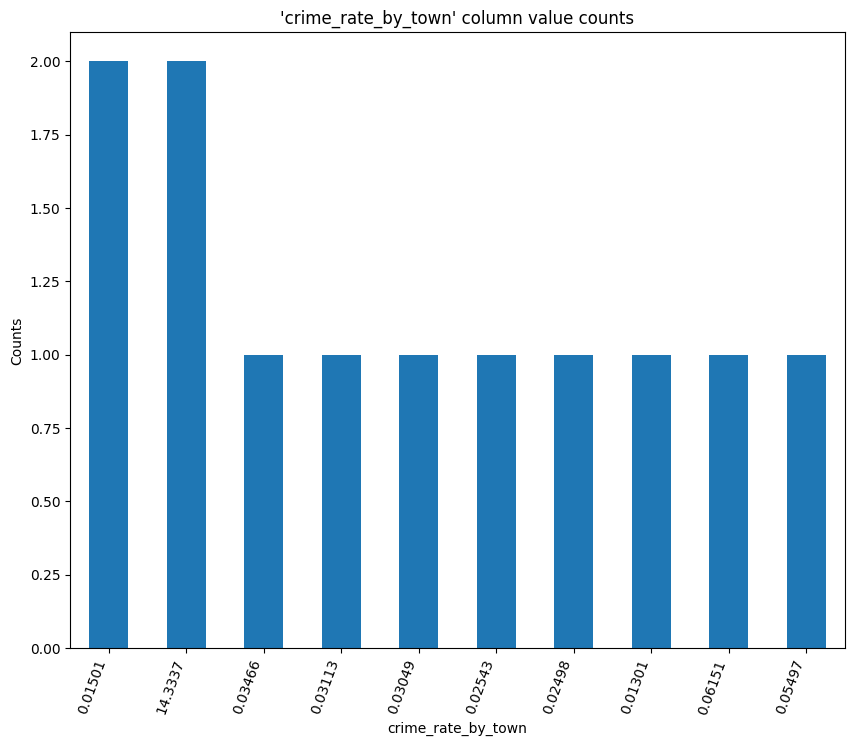

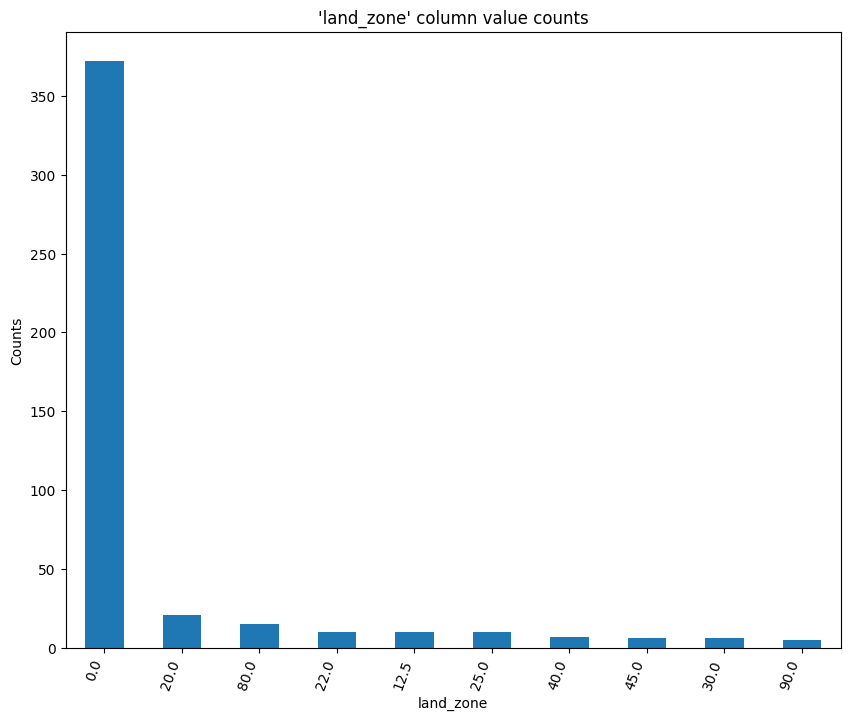

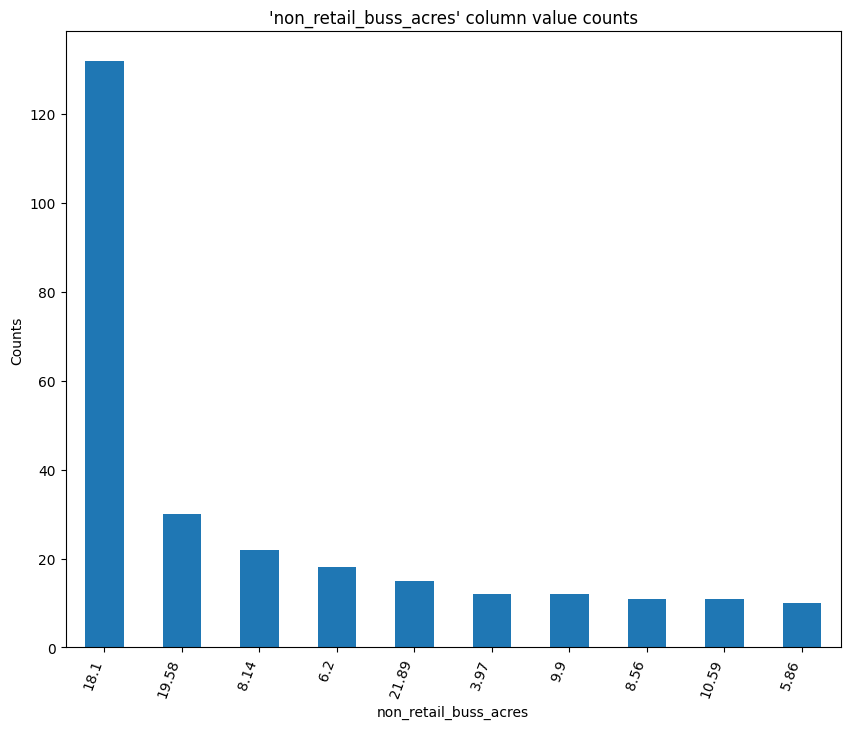

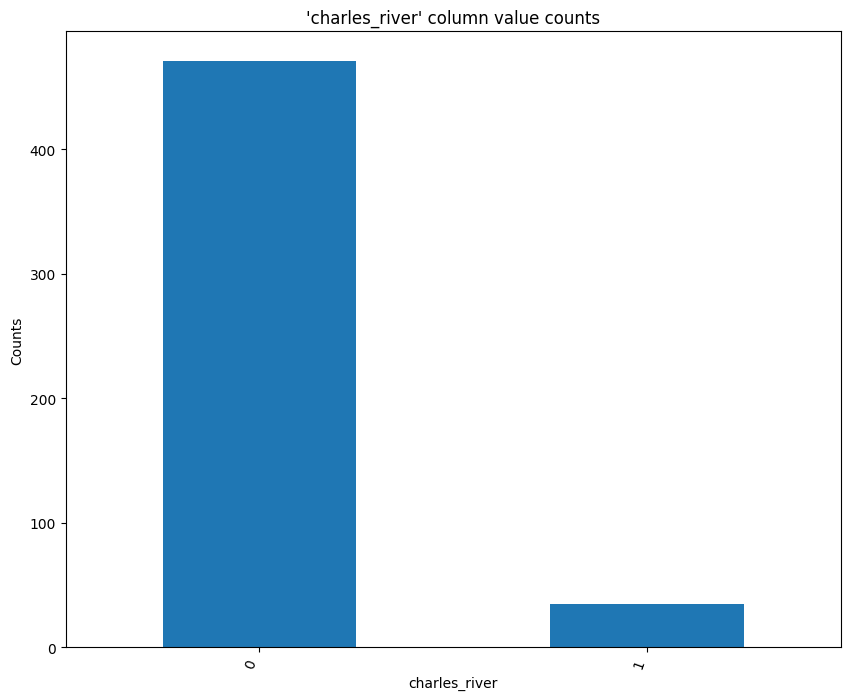

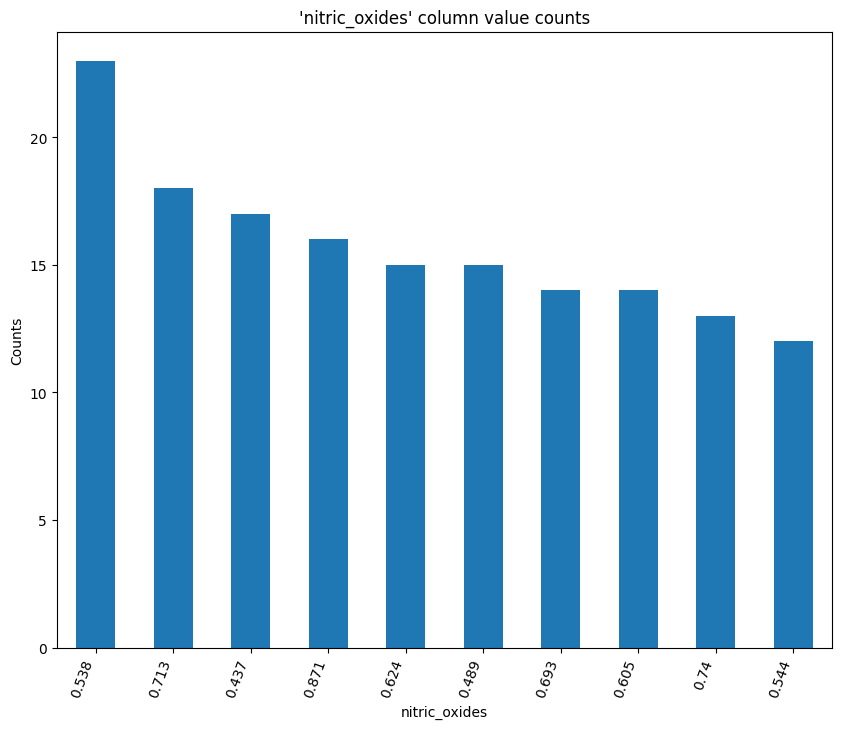

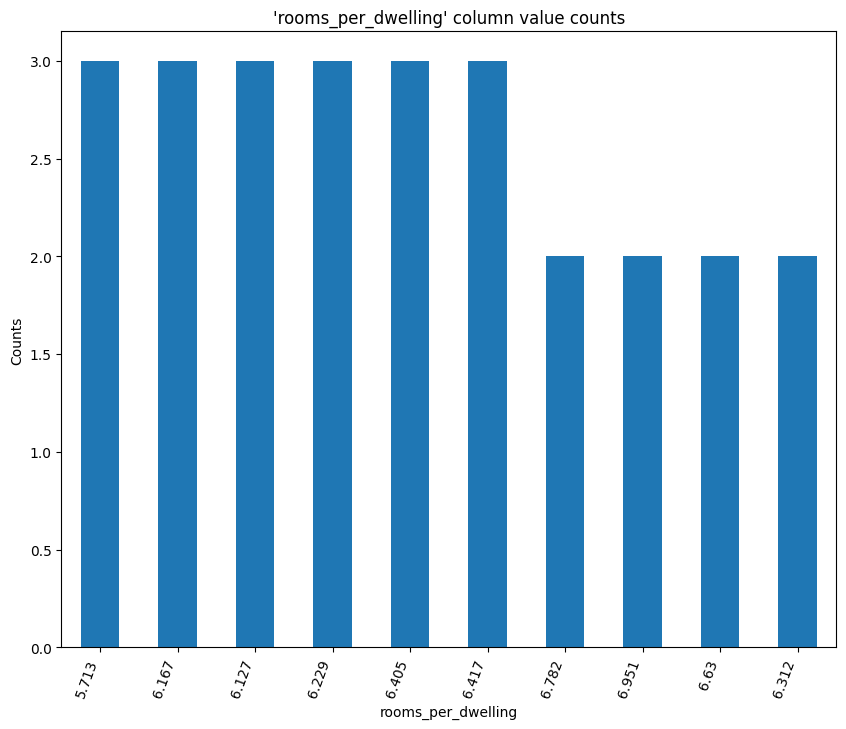

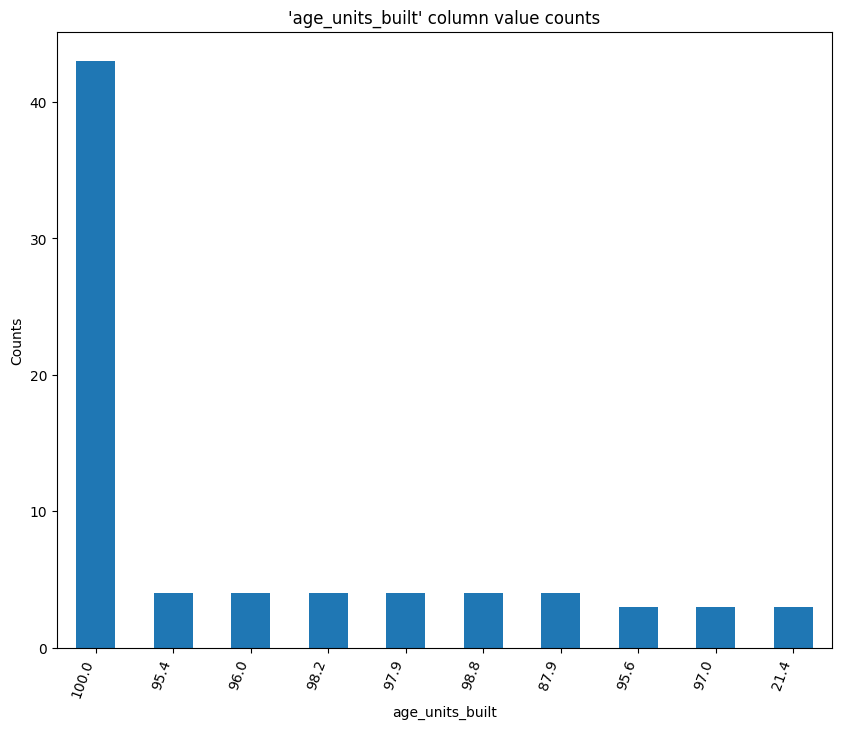

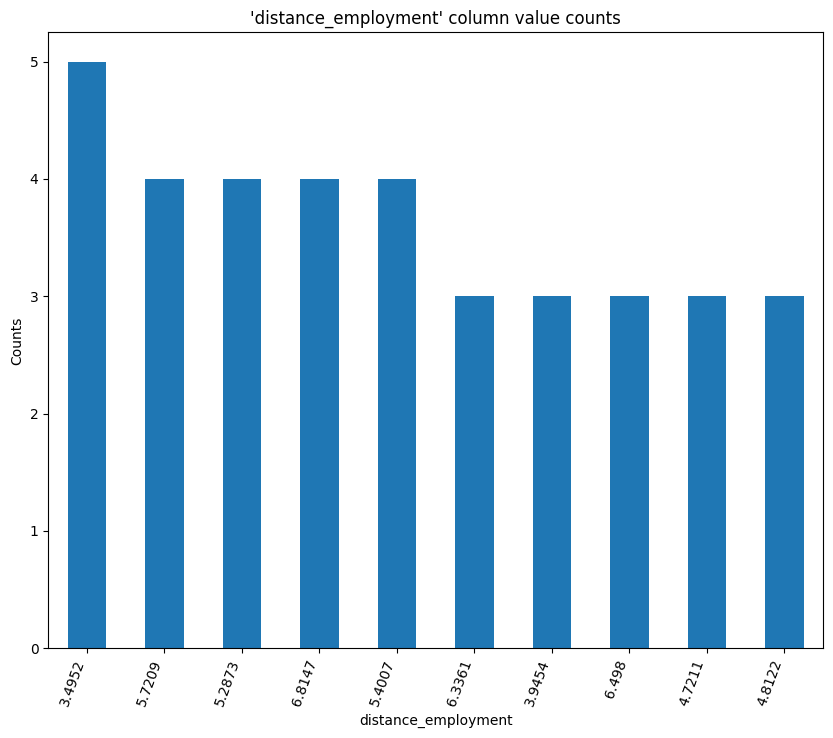

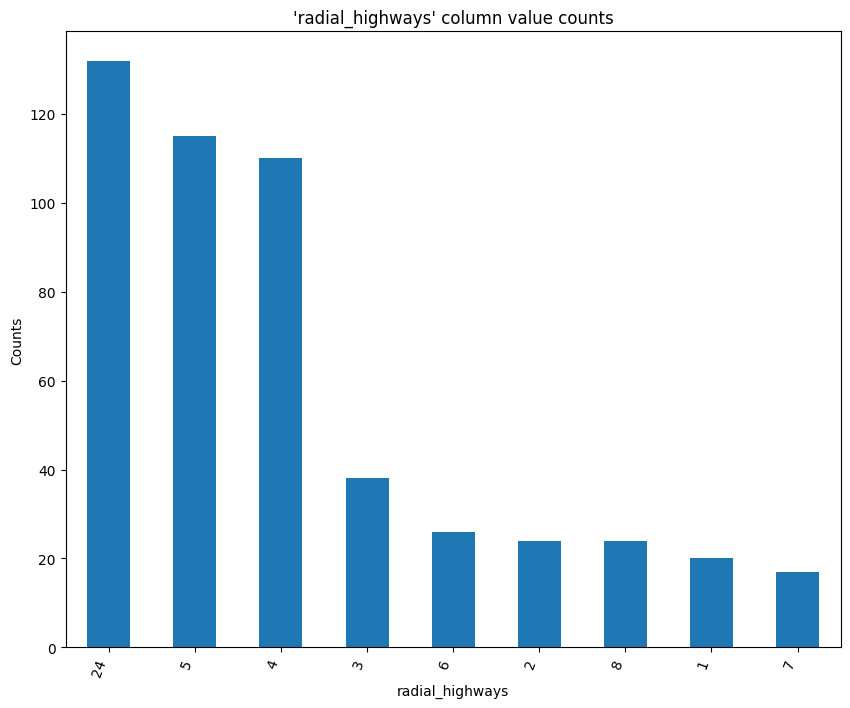

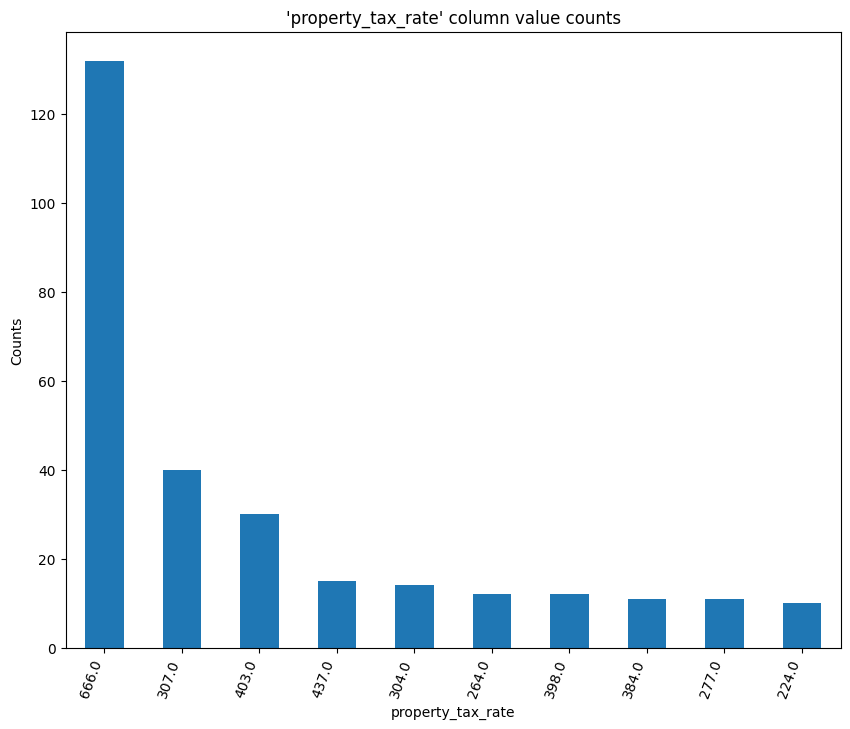

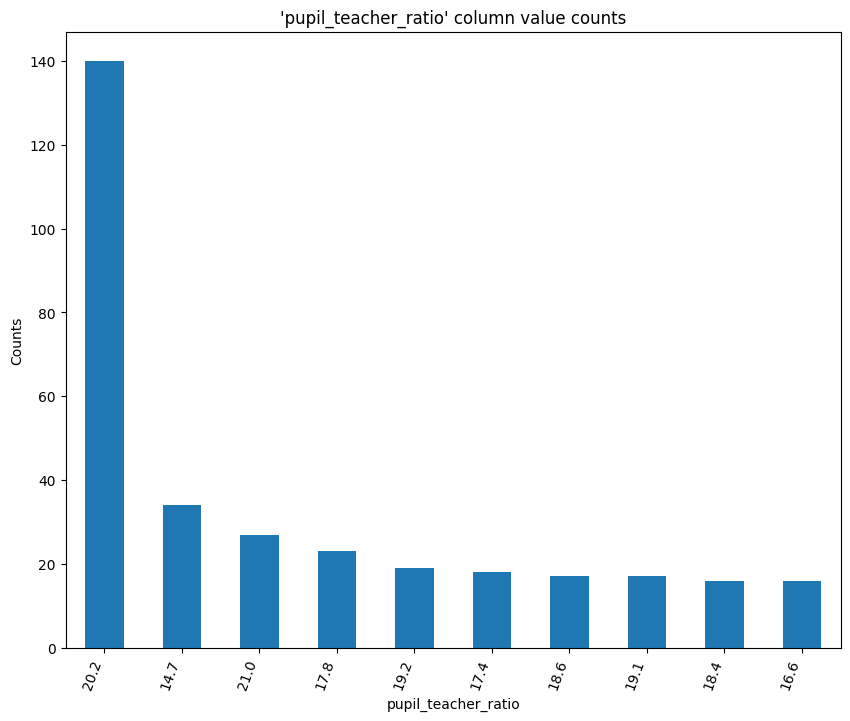

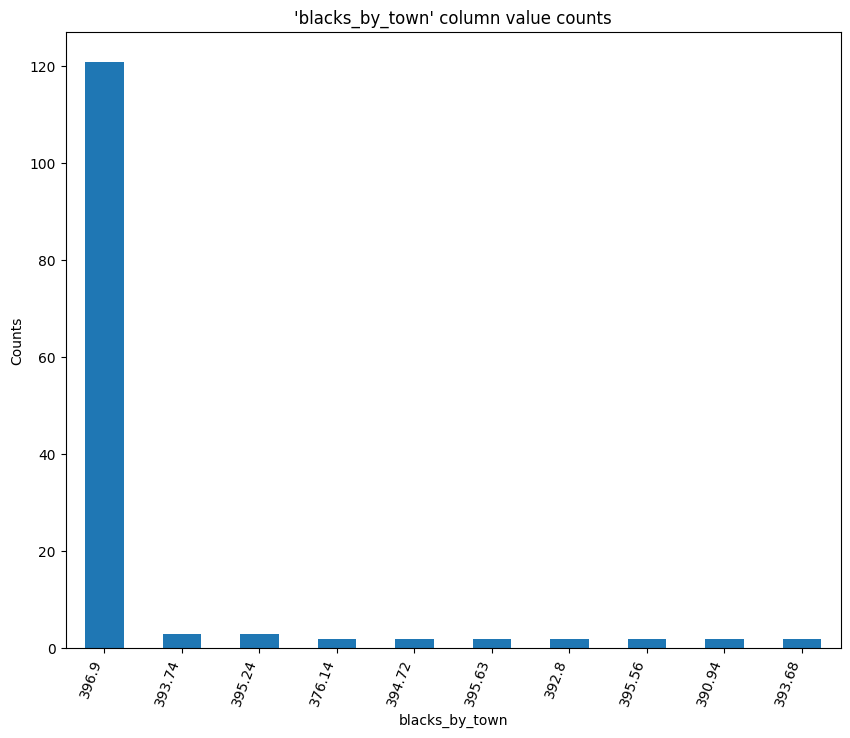

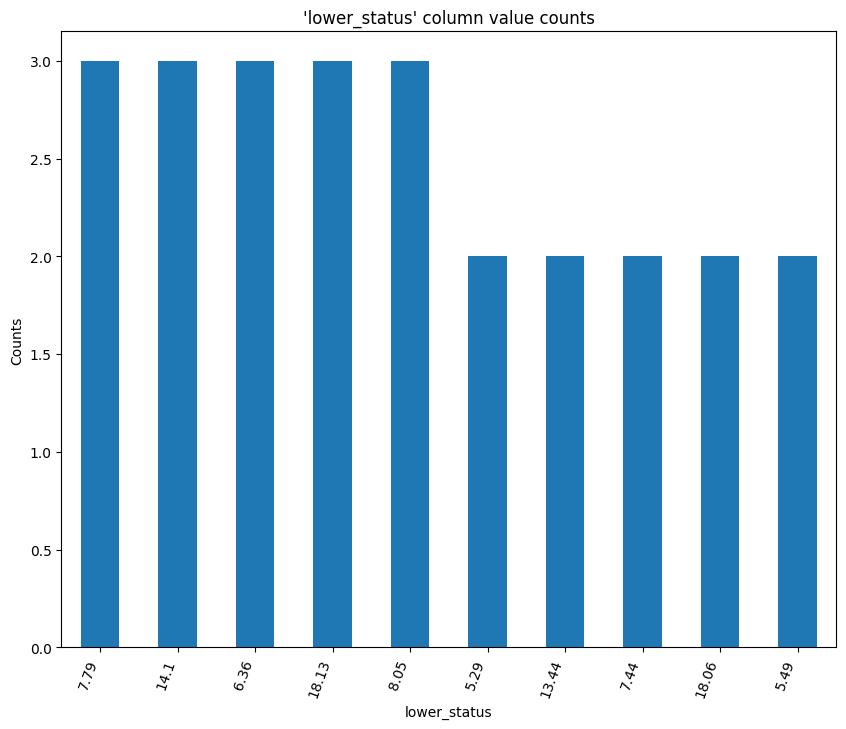

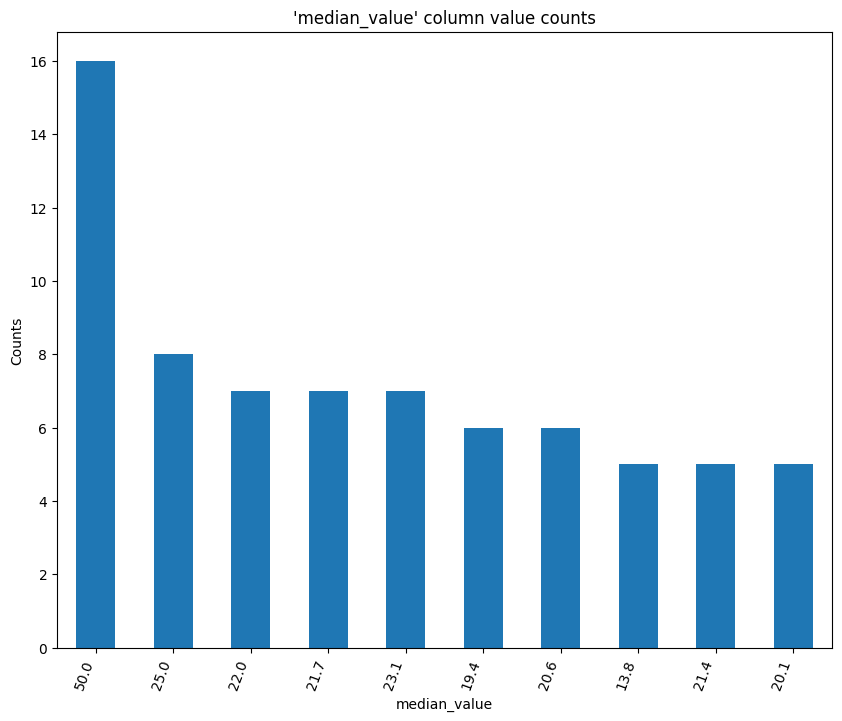

In [12]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

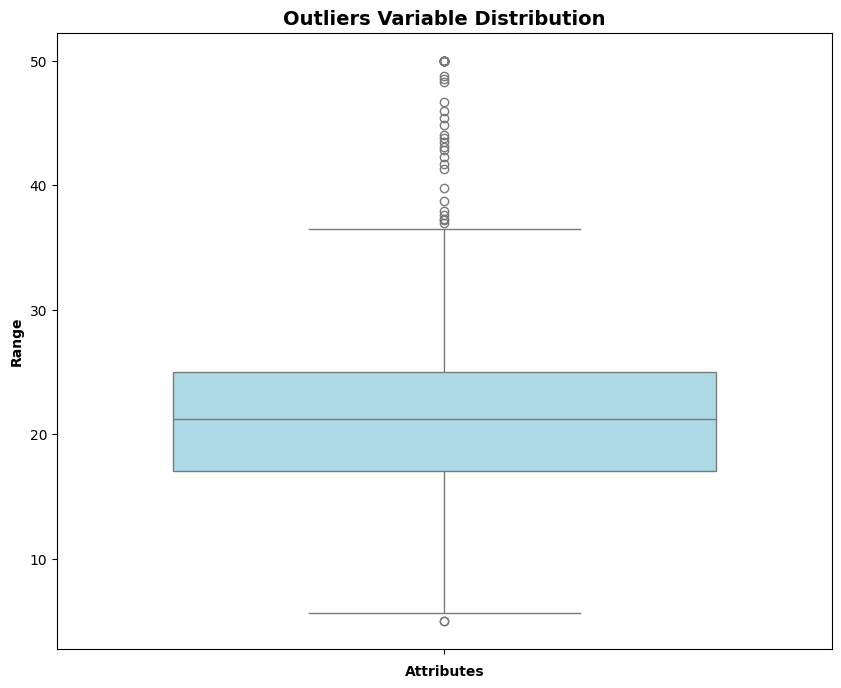

In [15]:
# Visualize Outlier Analysis one by one
# cols = ['unit_price', 'total_amount', 'shipping_cost', 'delivery_time_days'] 

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['median_value'], orient="v", 
 color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');
plt.xticks(rotation=80); 

In [19]:
# Removing (statistical) outliers for any column one by one
Q1 = df.median_value.quantile(0.25)
Q3 = df.median_value.quantile(0.75)
IQR = Q3 - Q1

print(f"Shape {df.shape} with Outliers")
df = df[(df.median_value >= Q1 - 1.5 * IQR) & (df.median_value <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers") 

Shape (457, 14) with Outliers
Shape (457, 14) without Outliers


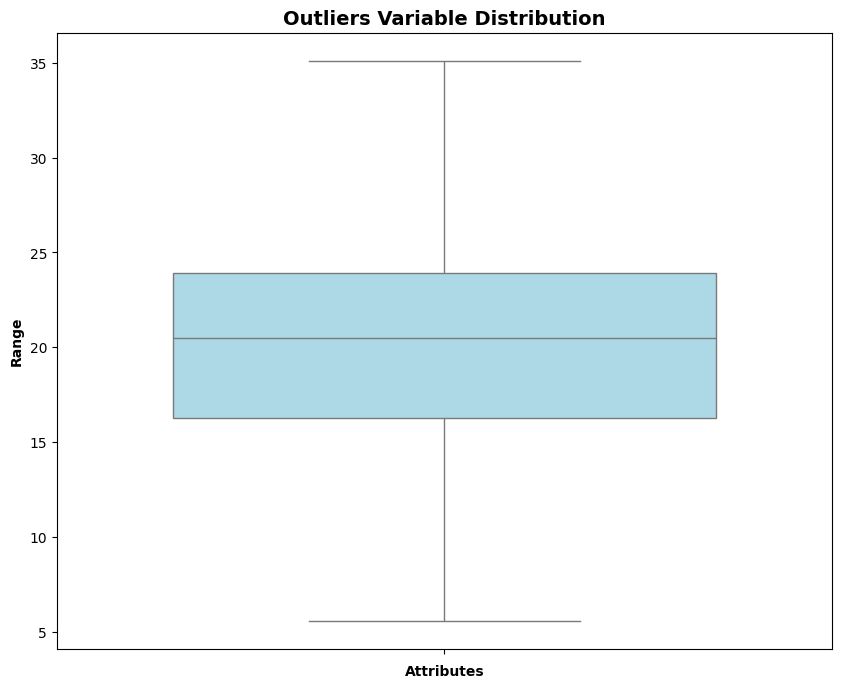

In [20]:
# Visualize Outlier Analysis one by one
# cols = ['unit_price', 'total_amount', 'shipping_cost', 'delivery_time_days'] 

plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df['median_value'], orient="v", 
 color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');
plt.xticks(rotation=80); 

## Machine Learning to imbalanced dataset

## LinearRegression

Dataset shape: (457, 13)
Feature names: Index(['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'charles_river', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status'], dtype='object')

X Train shape: (365, 13)
Y Train shape: (365,)
X Test shape: (92, 13)
Y Test shape: (92,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


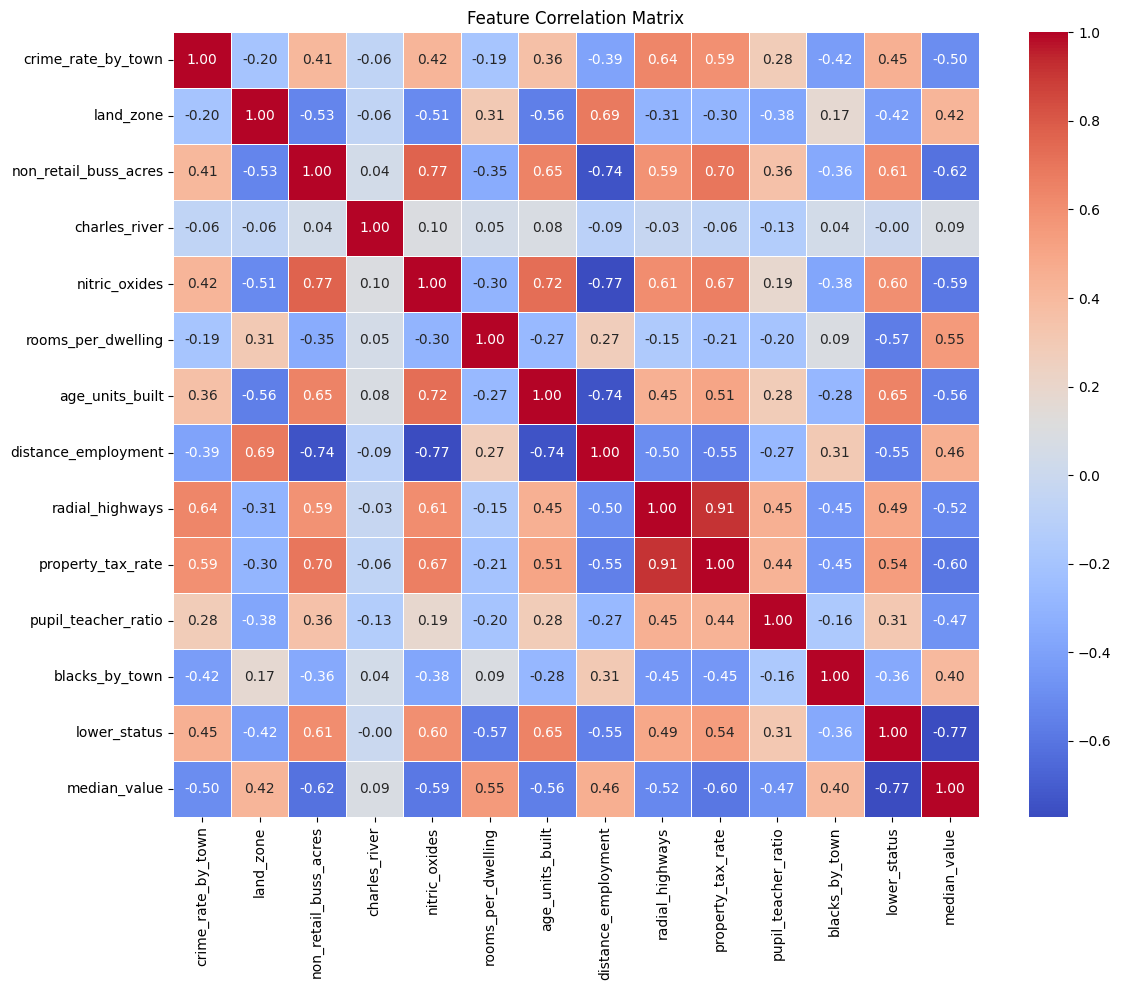

Feature correlation with target (median_value):
median_value             1.000000
rooms_per_dwelling       0.551499
distance_employment      0.459362
land_zone                0.422872
blacks_by_town           0.400694
charles_river            0.086633
pupil_teacher_ratio     -0.467914
crime_rate_by_town      -0.496787
radial_highways         -0.515614
age_units_built         -0.561272
nitric_oxides           -0.589519
property_tax_rate       -0.596101
non_retail_buss_acres   -0.618434
lower_status            -0.770062
Name: median_value, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 9.9470 ± 2.3794
Cross-Validation MAE: 2.3925 ± 0.3052
Cross-Validation R²: 0.7375 ± 0.0423
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 5

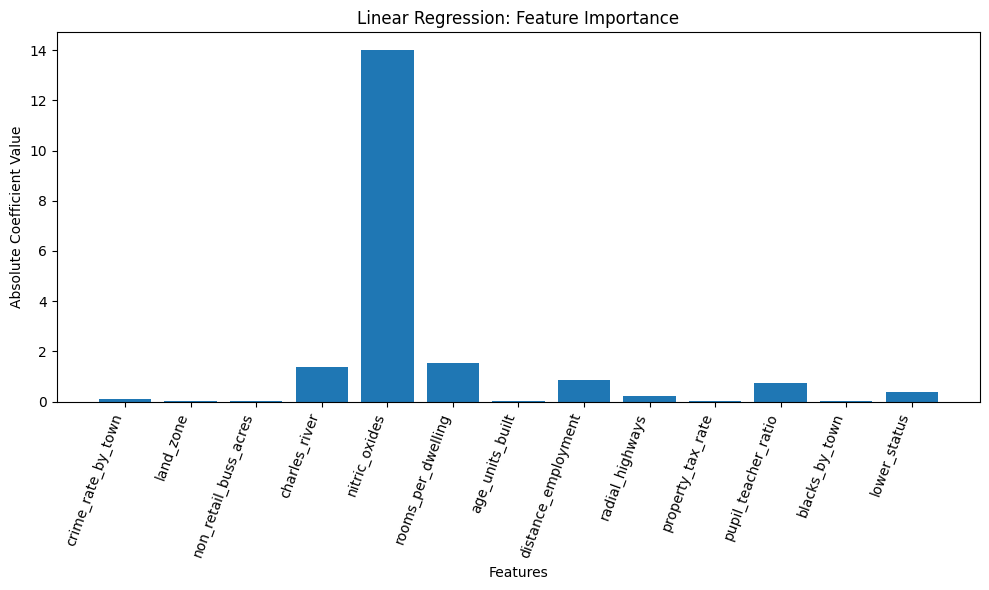

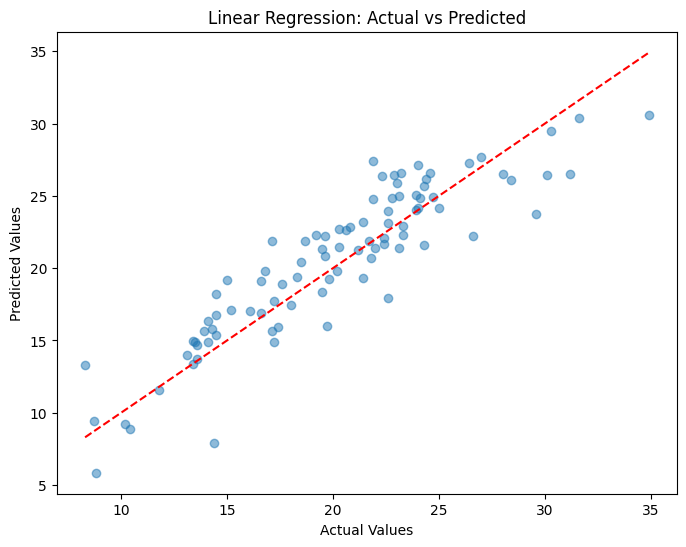

=== Scaled Linear Regression ===
MSE test set: 5.8226
MSE train set: 9.9408

R² Score test: 0.8024
R² Score train: 0.7499

MAE test set: 1.9213
MAE train set: 2.4114

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


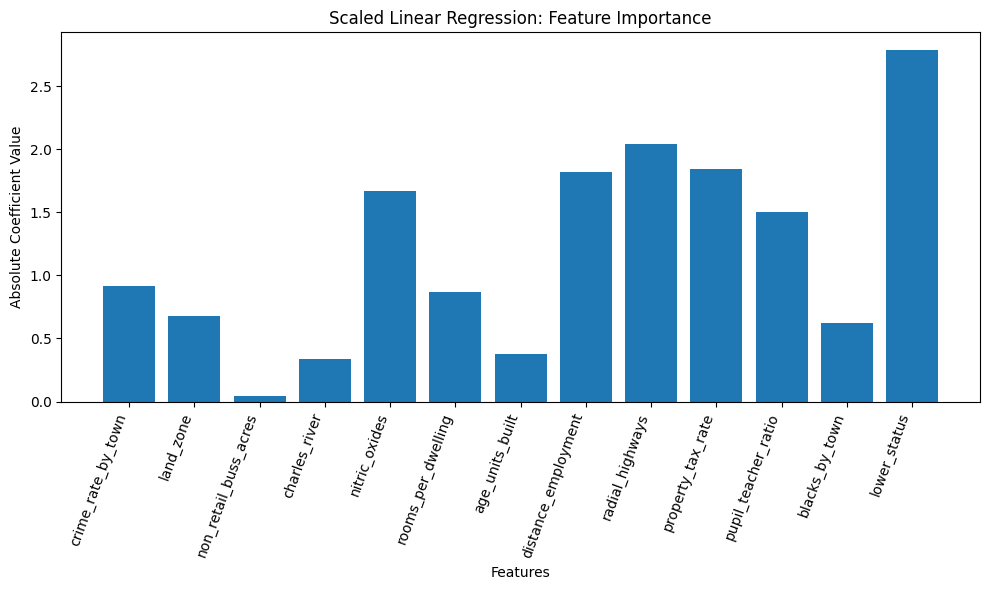

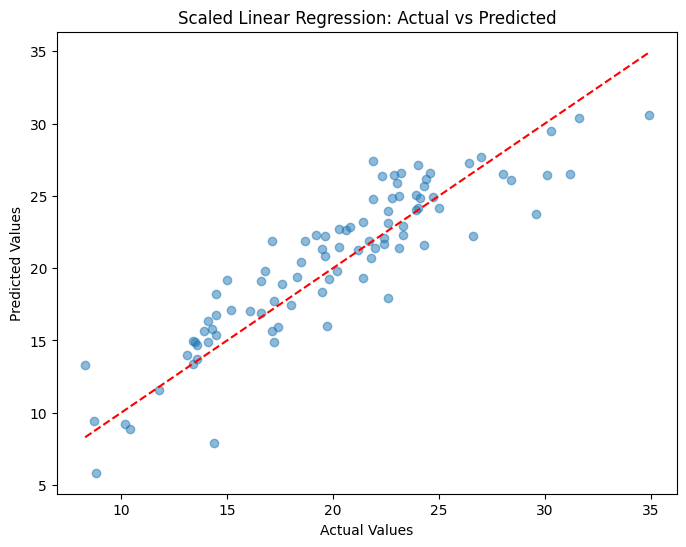

=== Feature Selection (SelectKBest) ===
MSE test set: 9.7352
MSE train set: 14.3067

R² Score test: 0.6696
R² Score train: 0.6400

MAE test set: 2.4875
MAE train set: 3.0220

Selected Features Selector : ['non_retail_buss_acres' 'nitric_oxides' 'age_units_built'
 'property_tax_rate' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


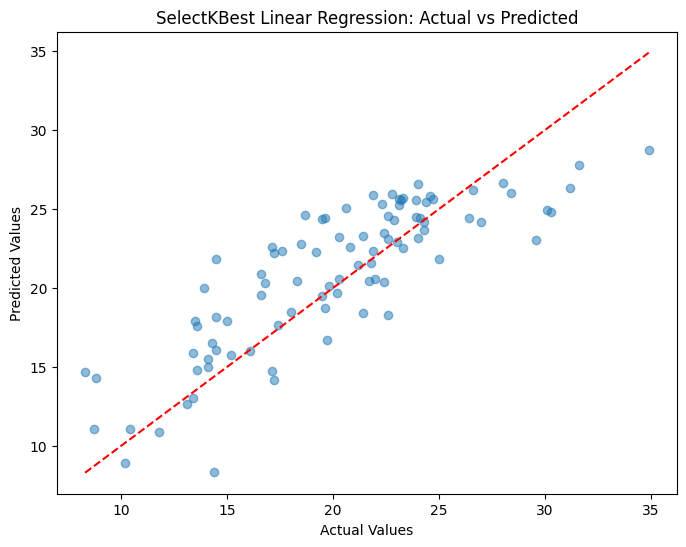

=== Feature Selection (RFE) ===
MSE test set: 8.5488
MSE train set: 12.2628

R² Score test: 0.7098
R² Score train: 0.6914

MAE test set: 2.3114
MAE train set: 2.8021

Selected Features Selector : ['nitric_oxides' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


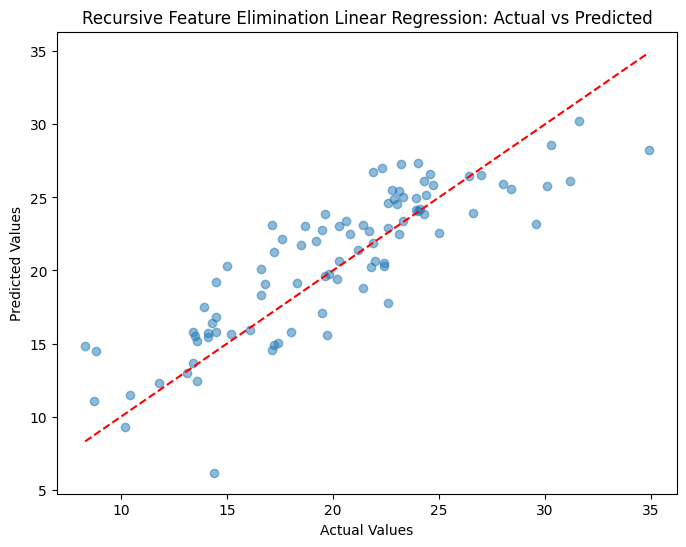

=== Polynomial Regression ===
MSE test set: 8.7522
MSE train set: 3.3183

R² Score test: 0.7029
R² Score train: 0.9165

MAE test set: 2.0206
MAE train set: 1.3265

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status'
 'crime_rate_by_town^2' 'crime_rate_by_town land_zone'
 'crime_rate_by_town non_retail_buss_acres'
 'crime_rate_by_town charles_river' 'crime_rate_by_town nitric_oxides'
 'crime_rate_by_town rooms_per_dwelling'
 'crime_rate_by_town age_units_built'
 'crime_rate_by_town distance_employment'
 'crime_rate_by_town radial_highways'
 'crime_rate_by_town property_tax_rate'
 'crime_rate_by_town pupil_teacher_ratio'
 'crime_rate_by_town blacks_by_town' 'crime_rate_by_town lower_status'
 'land_zone^2' 'land_zone non_retail_buss_acres' 'land_zone charles_river'
 'land_z

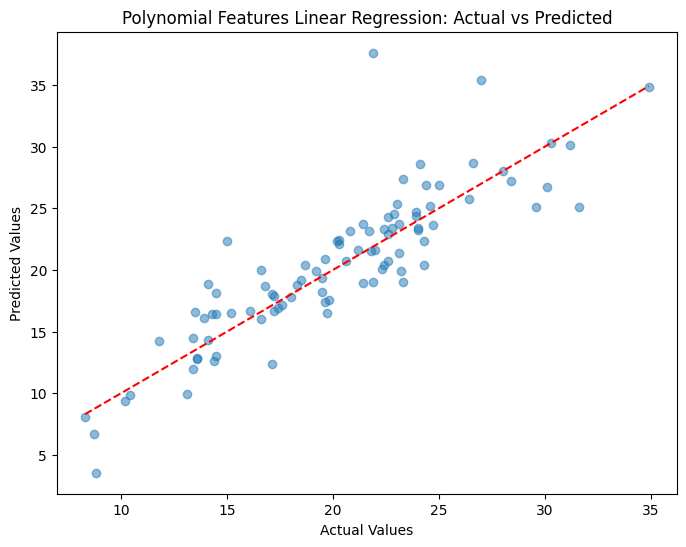

=== Ridge Regression ===
MSE test set:  5.7465
MSE train set: 10.0195

R² Score test: 0.8049
R² Score train:0.7479

MAE test set:  1.9246
MAE train set: 2.4259

Best alpha:    10.0000

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


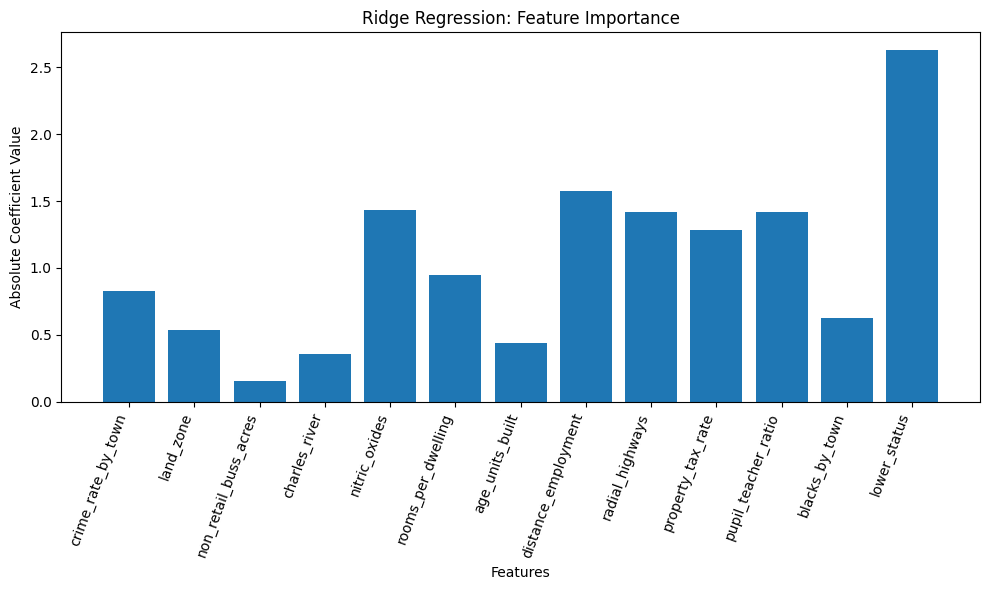

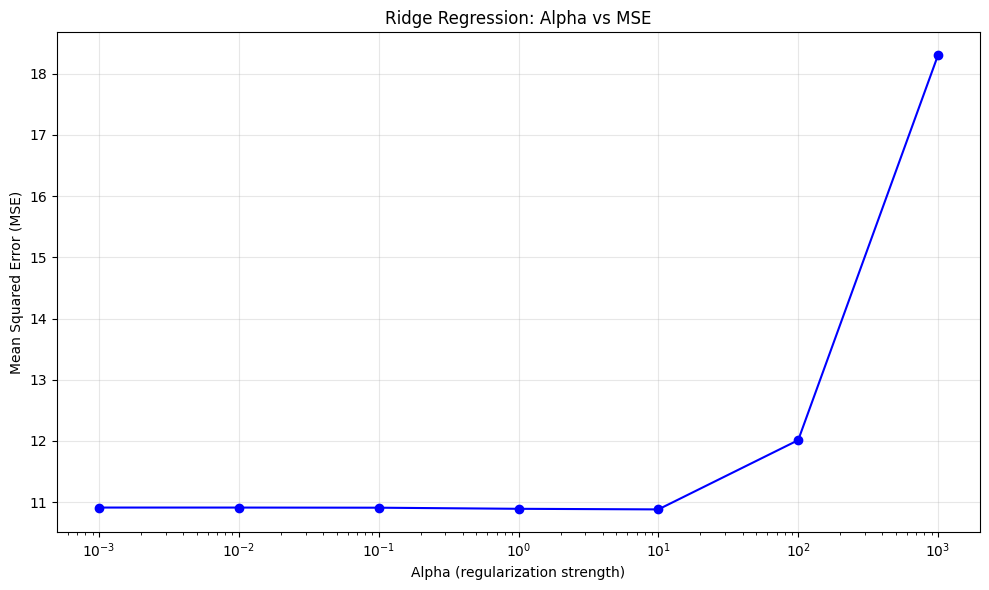

=== Lasso Regression ===
MSE test set: 5.8102
MSE train set: 9.9463

R² Score test: 0.8028
R² Score train: 0.7497

MAE test set: 1.9252
MAE train set: 2.4141

Best alpha: 0.01

Selected features: ['crime_rate_by_town' 'land_zone' 'charles_river' 'nitric_oxides'
 'rooms_per_dwelling' 'age_units_built' 'distance_employment'
 'radial_highways' 'property_tax_rate' 'pupil_teacher_ratio'
 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


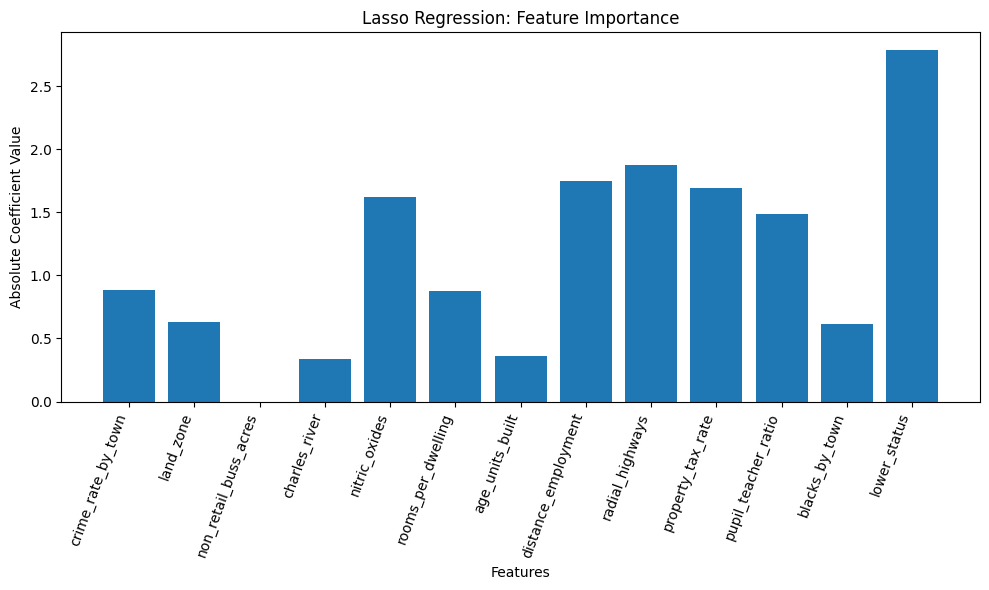

=== Elastic Net Regression ===
MSE test set: 5.7741
MSE train set: 9.9543

R² Score test: 0.8040
R² Score train: 0.7495

MAE test set: 1.9205
MAE train set: 2.4139

Best parameters: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


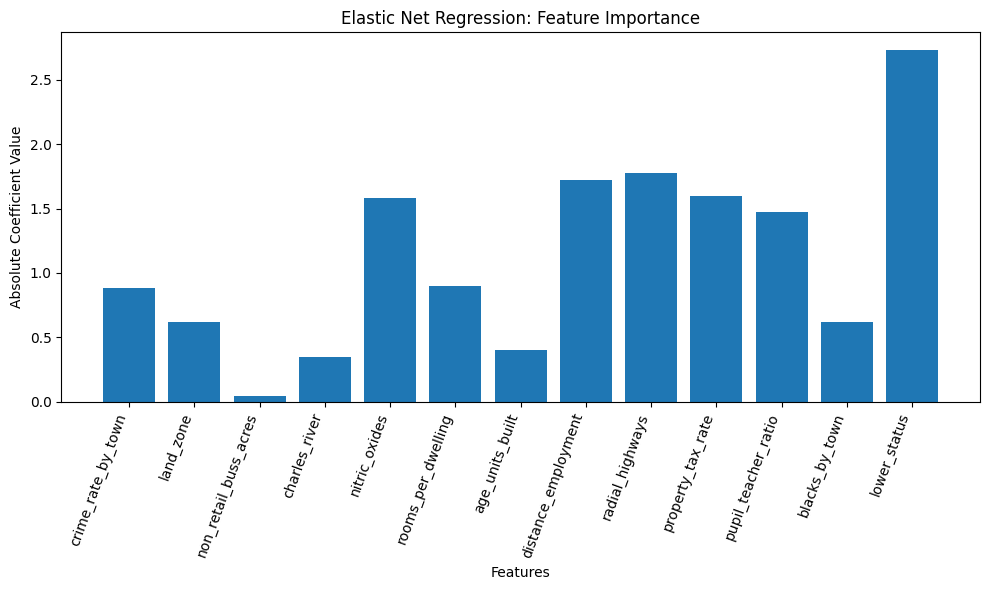

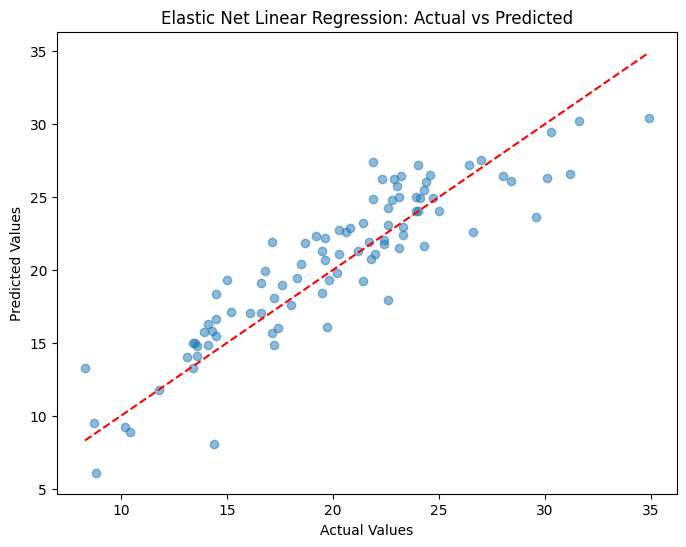

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                MAE       MSE        R²
Feature Selection (KBest)  9.735159  0.669566  2.487485
Polynomial Regression      8.752155  0.702931  2.020620
Feature Selection (RFE)    8.548774  0.709834  2.311366
Scaled Linear Regression   5.822579  0.802368  1.921331
Basic Linear Regression    5.822579  0.802368  1.921331
Lasso Regression           5.810176  0.802789  1.925233
Elastic Net                5.774114  0.804013  1.920533
Ridge Regression           5.746534  0.804949  1.924560
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Feature Selection (KBest)
Best model according to MSE: Feature Selection (KBest)
Best model according to RMSE: Feature Selection (KBest)
Best model according to R2_score: Feature Selecti

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['median_value'], axis=1)
y = df['median_value']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['median_value'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['median_value'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (median_value):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

## Machine Learning to balanced dataset

charles_river
0    430
1     27
Name: count, dtype: int64


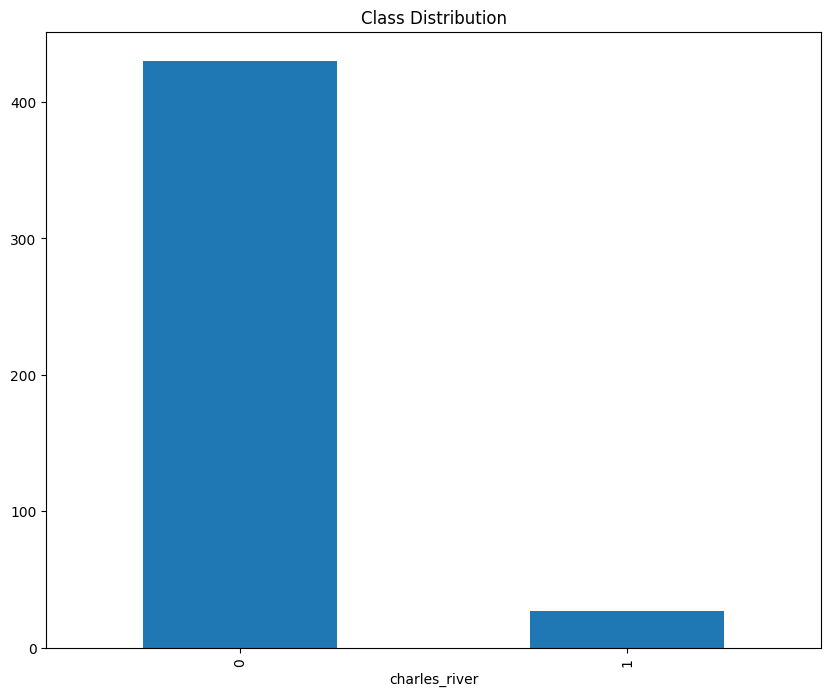

In [24]:
# Imbalance
# Visualize imbalance
print(df['charles_river'].value_counts())
df['charles_river'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [25]:
# Oversampling (Increase minority class)
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.charles_river == 0]
df_minority = df[df.charles_river == 1]

df_minority_upsampled = resample(df_minority, 
                                replace=True,     # sample with replacement
                                n_samples=len(df_majority),    # to match majority class
                                random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

In [27]:
# Always reset index (it’s a must to do)
df_balanced = df_balanced.reset_index(drop=True)

In [29]:
df_balanced.to_csv('balanced_housing.csv', index=False)

In [30]:
df = df_balanced

## LinearRegression

Dataset shape: (860, 13)
Feature names: Index(['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'charles_river', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status'], dtype='object')

X Train shape: (688, 13)
Y Train shape: (688,)
X Test shape: (172, 13)
Y Test shape: (172,)
-------------------------------------------------------------------------------------------------------------------------------
=== Linear Regression Tuning Examples ===
=== Feature Correlation Analysis ===


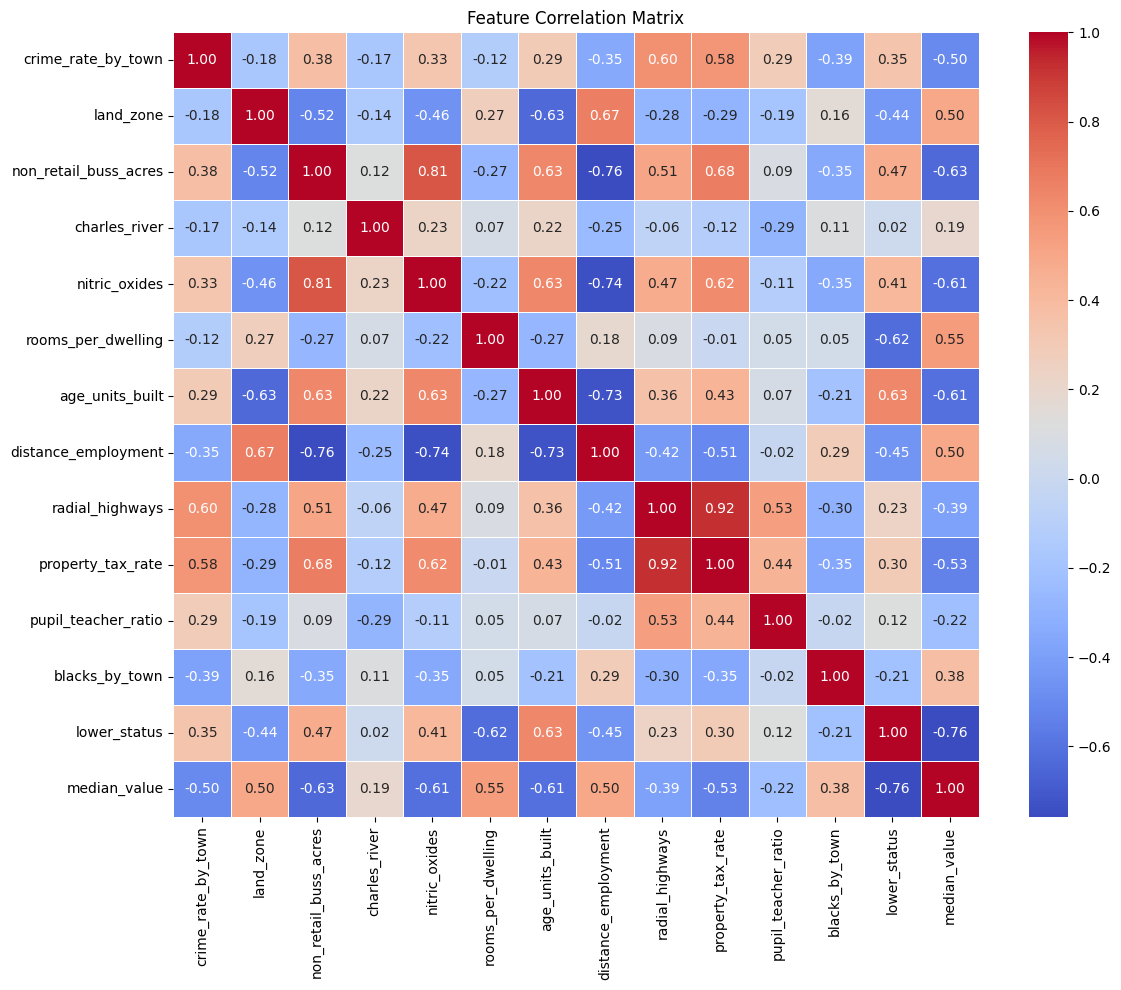

Feature correlation with target (median_value):
median_value             1.000000
rooms_per_dwelling       0.550960
distance_employment      0.496549
land_zone                0.495522
blacks_by_town           0.381409
charles_river            0.190217
pupil_teacher_ratio     -0.223566
radial_highways         -0.391659
crime_rate_by_town      -0.502498
property_tax_rate       -0.534205
age_units_built         -0.611072
nitric_oxides           -0.611392
non_retail_buss_acres   -0.634681
lower_status            -0.757401
Name: median_value, dtype: float64
-------------------------------------------------------------------------------------------------------------------------------
=== Cross-Validation ===
Cross-Validation MSE: 7.0479 ± 0.9282
Cross-Validation MAE: 1.9844 ± 0.1011
Cross-Validation R²: 0.7977 ± 0.0295
-------------------------------------------------------------------------------------------------------------------------------
=== Basic Linear Regression ===
MSE test set: 7

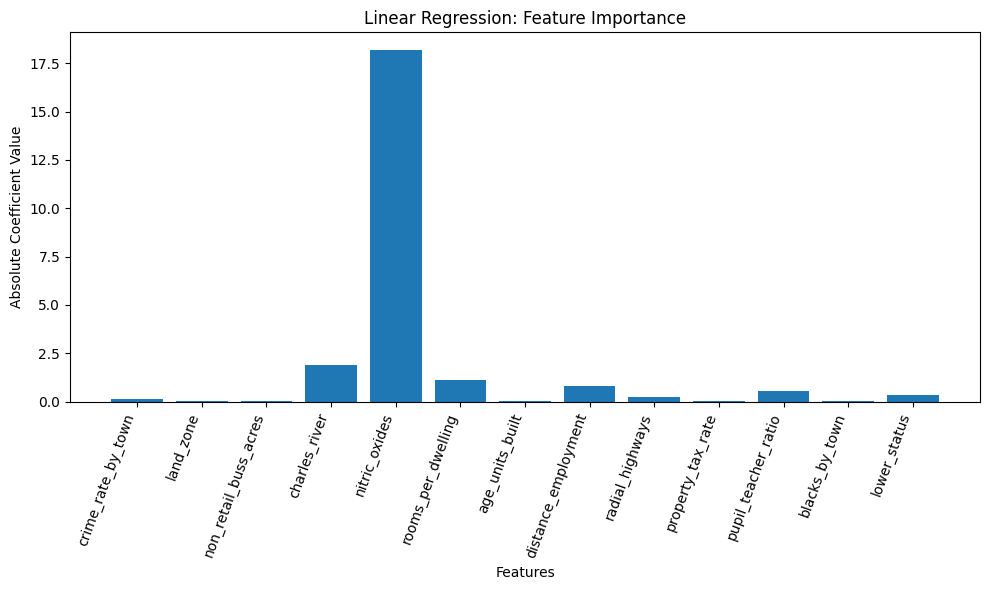

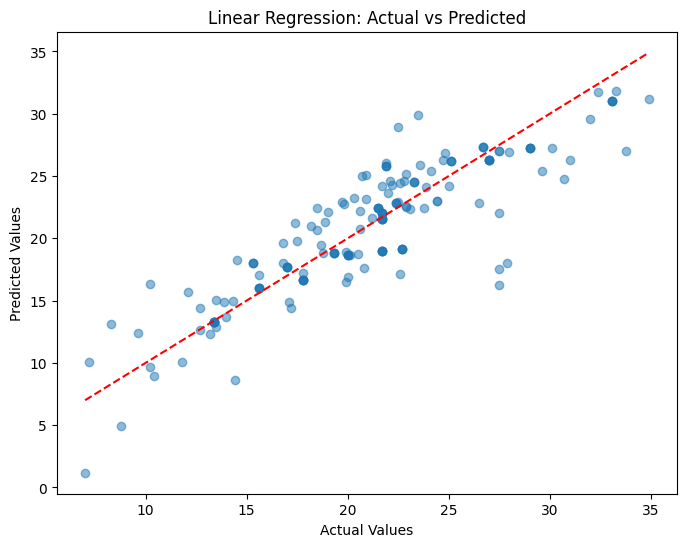

=== Scaled Linear Regression ===
MSE test set: 7.6609
MSE train set: 6.5412

R² Score test: 0.7649
R² Score train: 0.8164

MAE test set: 2.0085
MAE train set: 1.9375

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


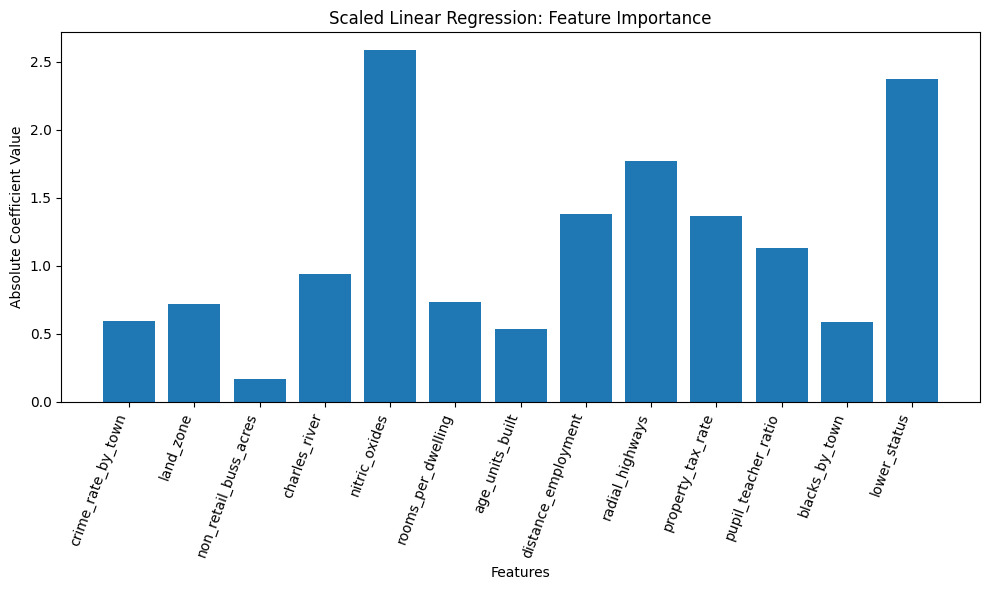

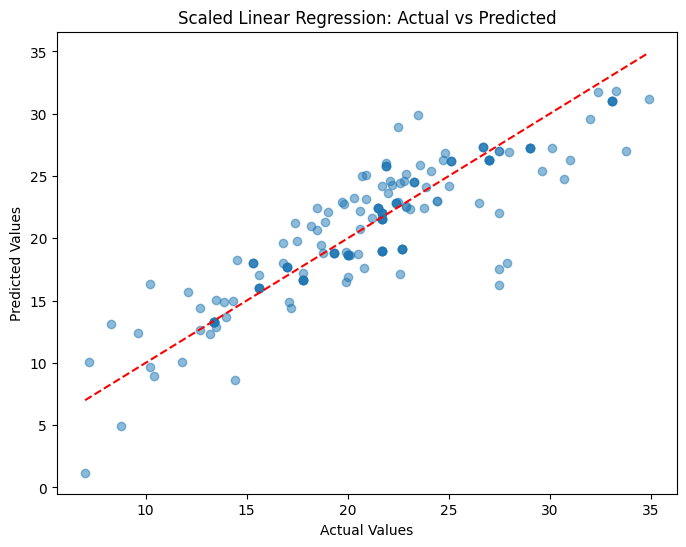

=== Feature Selection (SelectKBest) ===
MSE test set: 14.0181
MSE train set: 10.6798

R² Score test: 0.5697
R² Score train: 0.7003

MAE test set: 3.0787
MAE train set: 2.7423

Selected Features Selector : ['non_retail_buss_acres' 'nitric_oxides' 'rooms_per_dwelling'
 'age_units_built' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


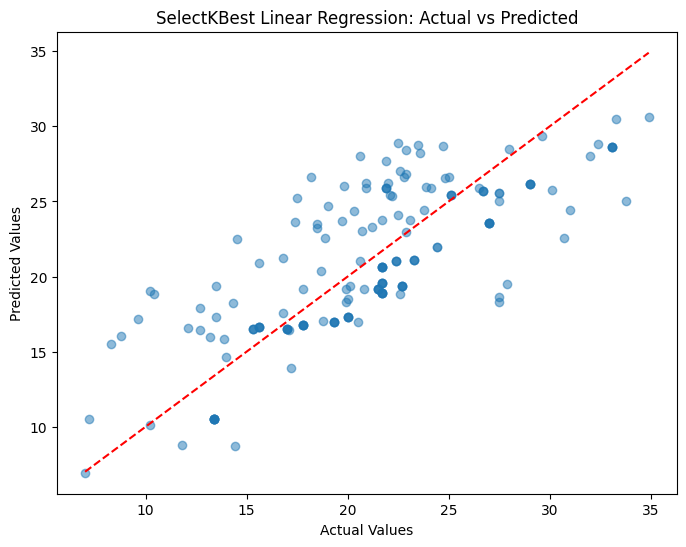

=== Feature Selection (RFE) ===
MSE test set: 11.0848
MSE train set: 7.8921

R² Score test: 0.6598
R² Score train: 0.7785

MAE test set: 2.5114
MAE train set: 2.1783

Selected Features Selector : ['charles_river' 'nitric_oxides' 'radial_highways' 'pupil_teacher_ratio'
 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


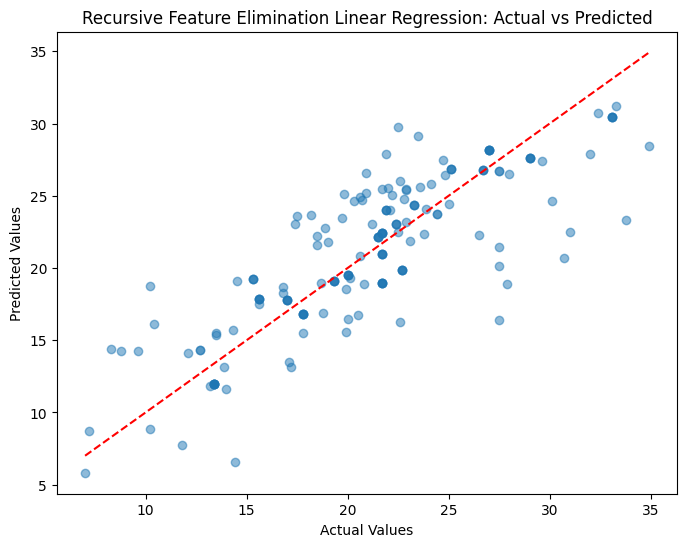

=== Polynomial Regression ===
MSE test set: 5.6644
MSE train set: 1.8576

R² Score test: 0.8261
R² Score train: 0.9479

MAE test set: 1.3132
MAE train set: 0.9065

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status'
 'crime_rate_by_town^2' 'crime_rate_by_town land_zone'
 'crime_rate_by_town non_retail_buss_acres'
 'crime_rate_by_town charles_river' 'crime_rate_by_town nitric_oxides'
 'crime_rate_by_town rooms_per_dwelling'
 'crime_rate_by_town age_units_built'
 'crime_rate_by_town distance_employment'
 'crime_rate_by_town radial_highways'
 'crime_rate_by_town property_tax_rate'
 'crime_rate_by_town pupil_teacher_ratio'
 'crime_rate_by_town blacks_by_town' 'crime_rate_by_town lower_status'
 'land_zone^2' 'land_zone non_retail_buss_acres' 'land_zone charles_river'
 'land_z

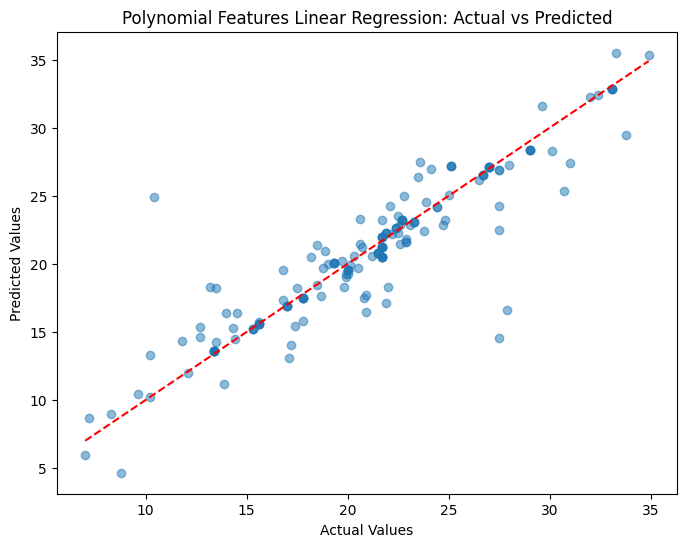

=== Ridge Regression ===
MSE test set:  7.6807
MSE train set: 6.5416

R² Score test: 0.7643
R² Score train:0.8164

MAE test set:  2.0104
MAE train set: 1.9383

Best alpha:    1.0000

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


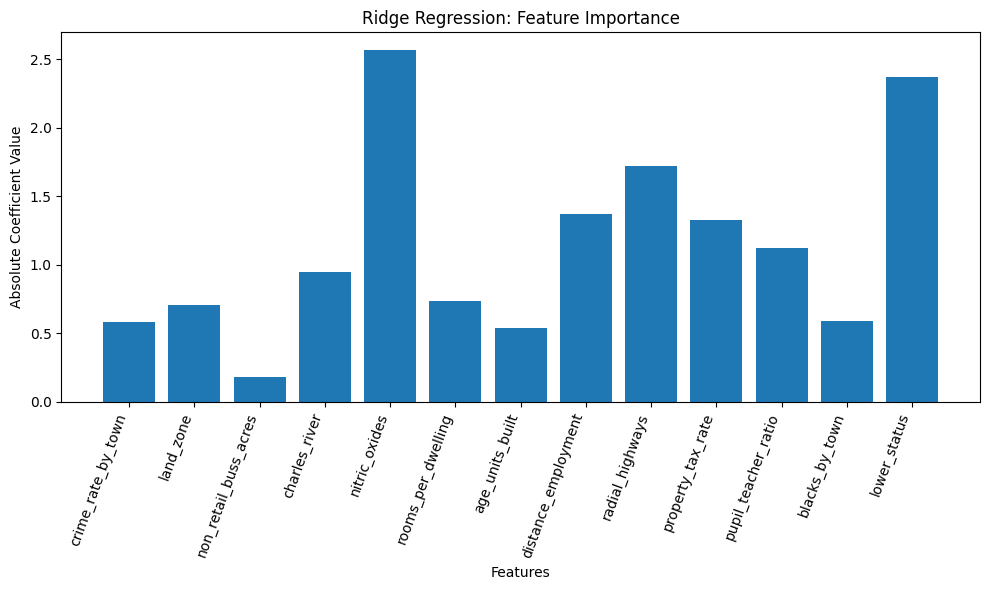

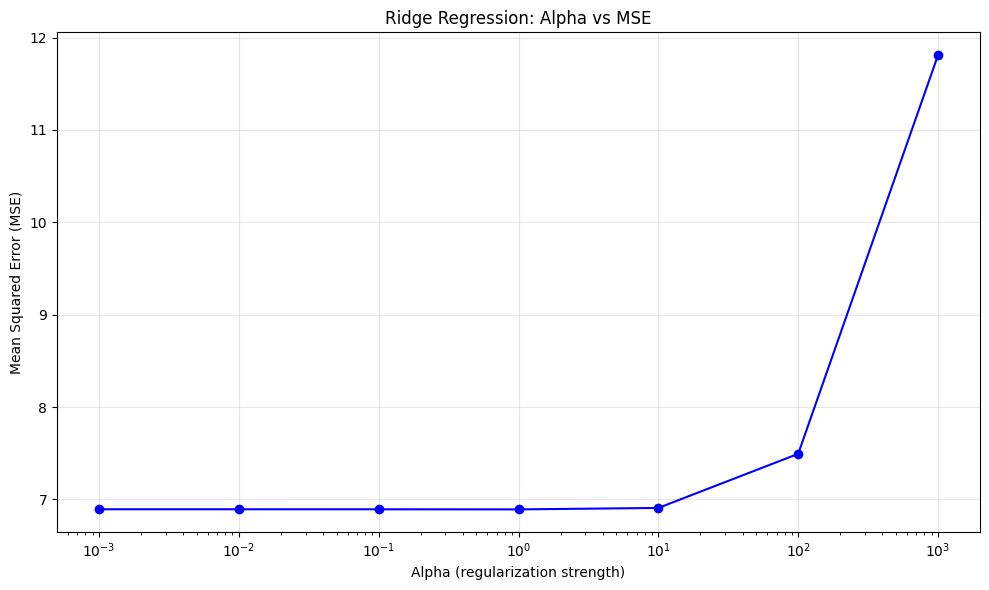

=== Lasso Regression ===
MSE test set: 7.6687
MSE train set: 6.5413

R² Score test: 0.7646
R² Score train: 0.8164

MAE test set: 2.0090
MAE train set: 1.9377

Best alpha: 0.001

Selected features: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


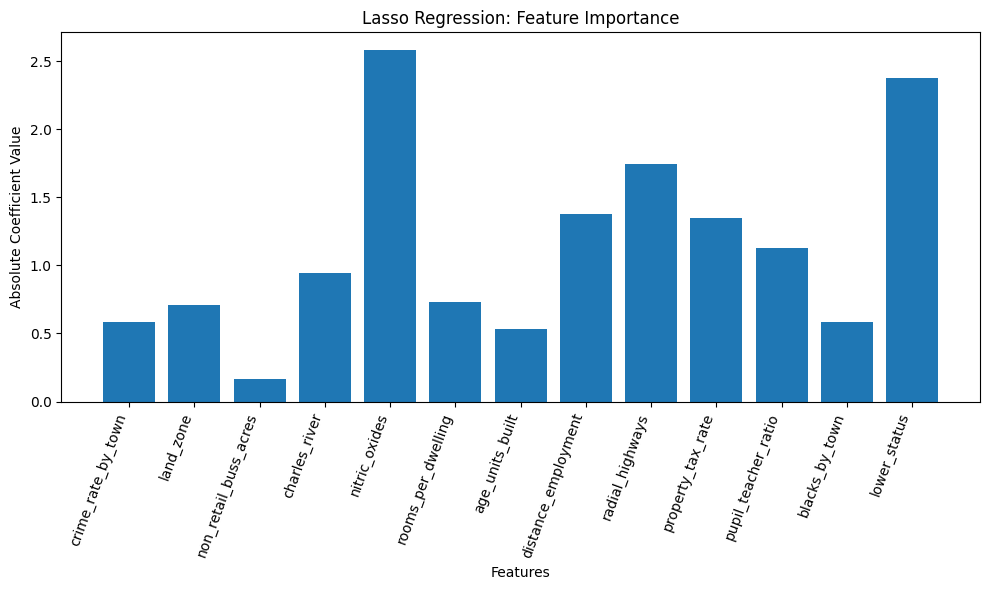

=== Elastic Net Regression ===
MSE test set: 7.6739
MSE train set: 6.5414

R² Score test: 0.7645
R² Score train: 0.8164

MAE test set: 2.0097
MAE train set: 1.9380

Best parameters: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}

Selected Features Coef_: ['crime_rate_by_town' 'land_zone' 'non_retail_buss_acres' 'charles_river'
 'nitric_oxides' 'rooms_per_dwelling' 'age_units_built'
 'distance_employment' 'radial_highways' 'property_tax_rate'
 'pupil_teacher_ratio' 'blacks_by_town' 'lower_status']
-------------------------------------------------------------------------------------------------------------------------------


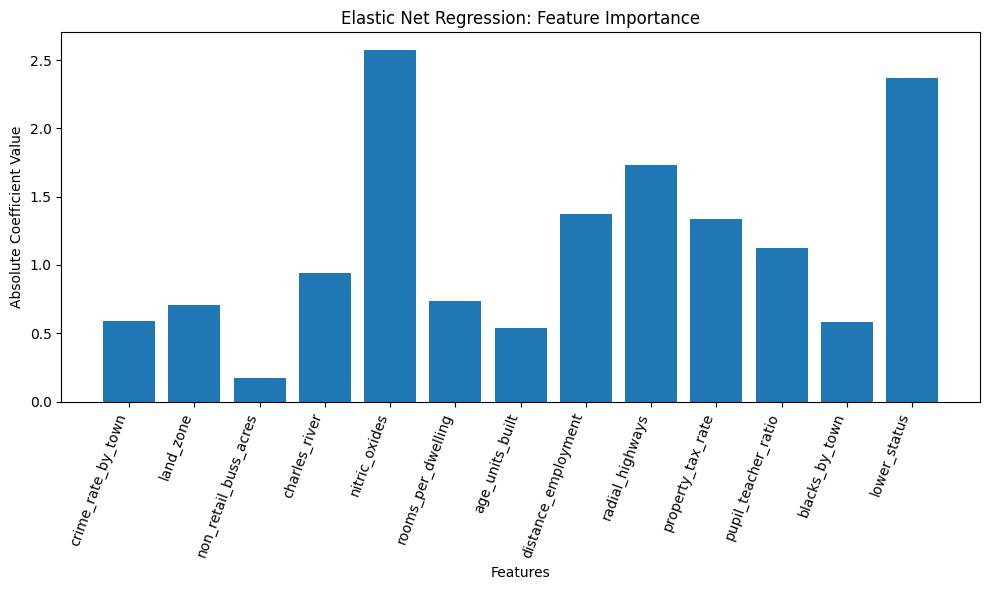

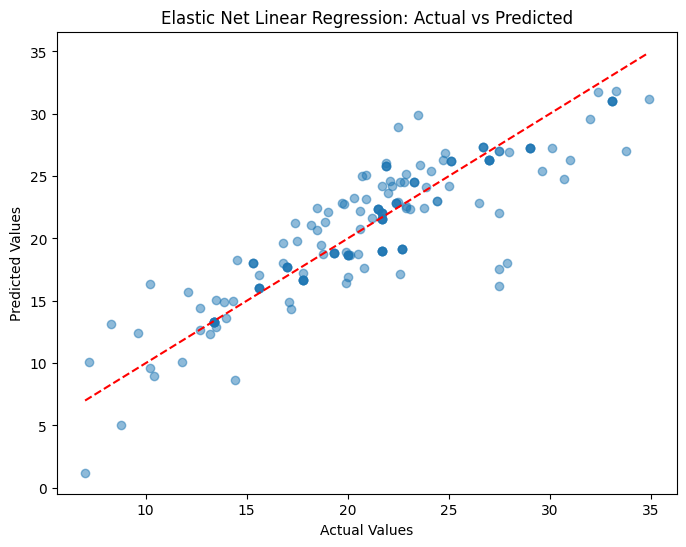

-------------------------------------------------------------------------------------------------------------------------------
=== Model Comparison ===
                                 MAE       MSE        R²
Feature Selection (KBest)  14.018149  0.569747  3.078735
Feature Selection (RFE)    11.084812  0.659779  2.511401
Ridge Regression            7.680691  0.764260  2.010403
Elastic Net                 7.673902  0.764468  2.009670
Lasso Regression            7.668661  0.764629  2.009047
Scaled Linear Regression    7.660857  0.764869  2.008508
Basic Linear Regression     7.660857  0.764869  2.008508
Polynomial Regression       5.664379  0.826146  1.313190
-------------------------------------------------------------------------------------------------------------------------------
Best model according to MAE: Feature Selection (KBest)
Best model according to MSE: Feature Selection (KBest)
Best model according to RMSE: Feature Selection (KBest)
Best model according to R2_score: Featur

In [31]:
# Set random seed for reproducibility
np.random.seed(42)

# Training & Splitting
X = df.drop(columns=['median_value'], axis=1)
y = df['median_value']

print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print() 

# For short dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Basic Linear Regression model
def basic_linear_regression():
    print("=== Basic Linear Regression ===")
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n") 
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)
    
    # Check which features were selected (non-zero coefficients)
    lr_coef = model.coef_
    selected_features = np.array(X_train.columns)[lr_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()

    return model, mse_test, r2_test, mae_test

# Feature Scaling
def scaled_linear_regression():
    print("=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    # Check which features were selected (non-zero coefficients)
    scaled_lr_coef = pipeline.named_steps['regression'].coef_
    selected_features = np.array(X_train.columns)[scaled_lr_coef != 0]
    print(f"Selected Features Coef_: {selected_features}") 
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(scaled_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Scaled Linear Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scaled Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with SelectKBest
def feature_selection_kbest():
    print("=== Feature Selection (SelectKBest) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectKBest(f_regression, k=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('SelectKBest Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Feature Selection with Recursive Feature Elimination (RFE)
def feature_selection_rfe():
    print("=== Feature Selection (RFE) ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', RFE(LinearRegression(), n_features_to_select=5)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    
    selected_features = np.array(X_train.columns)[pipeline.named_steps['selector'].get_support()]
    print(f"Selected Features Selector : {selected_features}") 
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Recursive Feature Elimination Linear Regression: Actual vs Predicted')
    plt.show() 
    
    return pipeline, mse_test, r2_test, mae_test

# Polynomial Features
def polynomial_regression():
    print("=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}") 

    # Get the polynomial feature names
    poly_features = pipeline.named_steps['poly'].get_feature_names_out(X_train.columns)
    
    # Get coefficients from the regression step
    poly_coef = pipeline.named_steps['regression'].coef_
    
    # Find selected features (non-zero coefficients)
    selected_features = poly_features[poly_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Polynomial Features Linear Regression: Actual vs Predicted')
    plt.show()  
    
    return pipeline, mse_test, r2_test, mae_test

# Regularized Linear Regression - Ridge
def ridge_regression():
    print("=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)
    
    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set:  {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train:{r2_train:.4f}\n")
    print(f"MAE test set:  {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")
    print(f"Best alpha:    {grid_search.best_params_['ridge__alpha']:.4f}")
  
    # Check which features were selected (non-zero coefficients)
    ridge_lr_coef = grid_search.best_estimator_['ridge'].coef_
    selected_features = np.array(X_train.columns)[ridge_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(ridge_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Ridge Regression: Feature Importance')
    plt.tight_layout()
    plt.show() 
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores, 'b-o')
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Regularized Linear Regression - Lasso
def lasso_regression():
    print("=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")   
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}") 
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    selected_features = np.array(X_train.columns)[lasso_coef != 0]
    print(f"\nSelected features: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(lasso_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse_test, r2_test, mae_test

# Elastic Net
def elastic_net_regression():
    print("=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train) 

    # Evaluate the model
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    print(f"MSE test set: {mse_test:.4f}")
    print(f"MSE train set: {mse_train:.4f}\n")
    print(f"R² Score test: {r2_test:.4f}")
    print(f"R² Score train: {r2_train:.4f}\n")
    print(f"MAE test set: {mae_test:.4f}")
    print(f"MAE train set: {mae_train:.4f}\n")    
    print(f"Best parameters: {grid_search.best_params_}")

    # Check which features were selected (non-zero coefficients)
    elastic_lr_coef = grid_search.best_estimator_['elasticnet'].coef_
    selected_features = np.array(X_train.columns)[elastic_lr_coef != 0]
    print(f"\nSelected Features Coef_: {selected_features}")
    print("-" * 127) 
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(X_train.columns, np.abs(elastic_lr_coef))
    plt.xticks(rotation=70, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Elastic Net Regression: Feature Importance')
    plt.tight_layout()
    plt.show()  
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Elastic Net Linear Regression: Actual vs Predicted')
    plt.show() 
    print("-" * 127) 
    
    return best_model, mse_test, r2_test, mae_test

# Cross-validation with MAE, MSE, and R² scores
def cross_validation_example():
    print("-" * 127)
    print("=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Calculate different metrics
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(mse_scores)
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation MAE: {mae_scores.mean():.4f} ± {mae_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print("-" * 127) 
    
    return mse_scores, mae_scores, r2_scores, rmse_scores
        
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
        'Feature Selection (KBest)': feature_selection_kbest(),
        'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
        'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }

    # Extract MSE and R² scores
    results = {name: {'MAE': mae_scores, 'MSE': mse_scores, 'R²': r2_scores} 
           for name, (_, mae_scores, mse_scores, r2_scores) in models.items()} 

    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("=== Model Comparison ===")
    print(results_df)
    print("-" * 127) 
    
    return results_df 

    # Plot comparison
    plt.figure(figsize=(12, 15))  # Increase height for 3 subplots

    plt.subplot(3, 1, 1)  # This now works with 3 rows
    plt.bar(results_df.index, results_df['MAE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE (lower is better)')
    
    plt.subplot(3, 1, 2)  # Change to 3 rows
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(3, 1, 3)  # Change to 3 rows
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=70, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')

    plt.tight_layout()
    plt.show()
    
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=X_train.columns)  # Always change the df value based on the df's name you're using
    X_df['median_value'] = y_train  # Always change the X_df value 
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    target_corr = corr['median_value'].sort_values(ascending=False) # Always change the target_coor value 
    print("Feature correlation with target (median_value):")  # Always change the variable value 
    print(target_corr)
    
    return corr

# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print(f"Best model according to MAE: {results.index[0]}")
    print(f"Best model according to MSE: {results.index[0]}")
    print(f"Best model according to RMSE: {results.index[0]}")
    print(f"Best model according to R2_score: {results.index[0]}")
    print("-" * 127) 

In [32]:
# Classifiers Models
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier)

Dataset shape: (860, 13)
Feature names: Index(['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status', 'median_value'], dtype='object')
Number of classes: 2
Class distribution: [430 430]

X Train shape: (688, 13)
Y Train shape: (688,)
X Test shape: (172, 13)
Y Test shape: (172,)
-------------------------------------------------------------------------------------------------------------------------------
--- Basic Model Performance ---
Accuracy test set: 0.8488
Accuracy train set: 0.8445

Classification Report:
Classification Report test set:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        84
           1       0.86      0.84      0.85        88

    accuracy                           0.85       172
   macro avg       0.85      0.85      0.85       

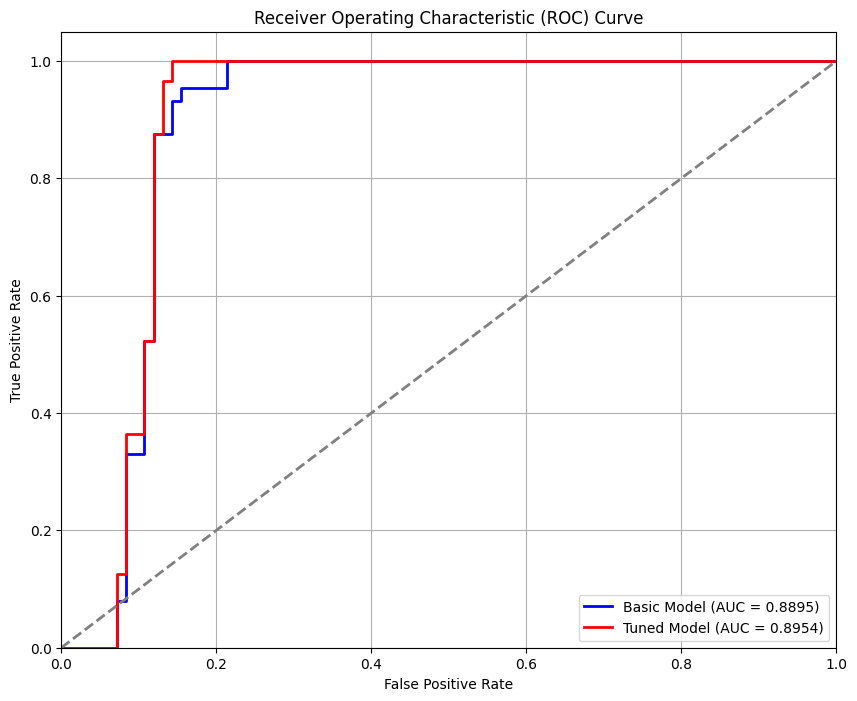

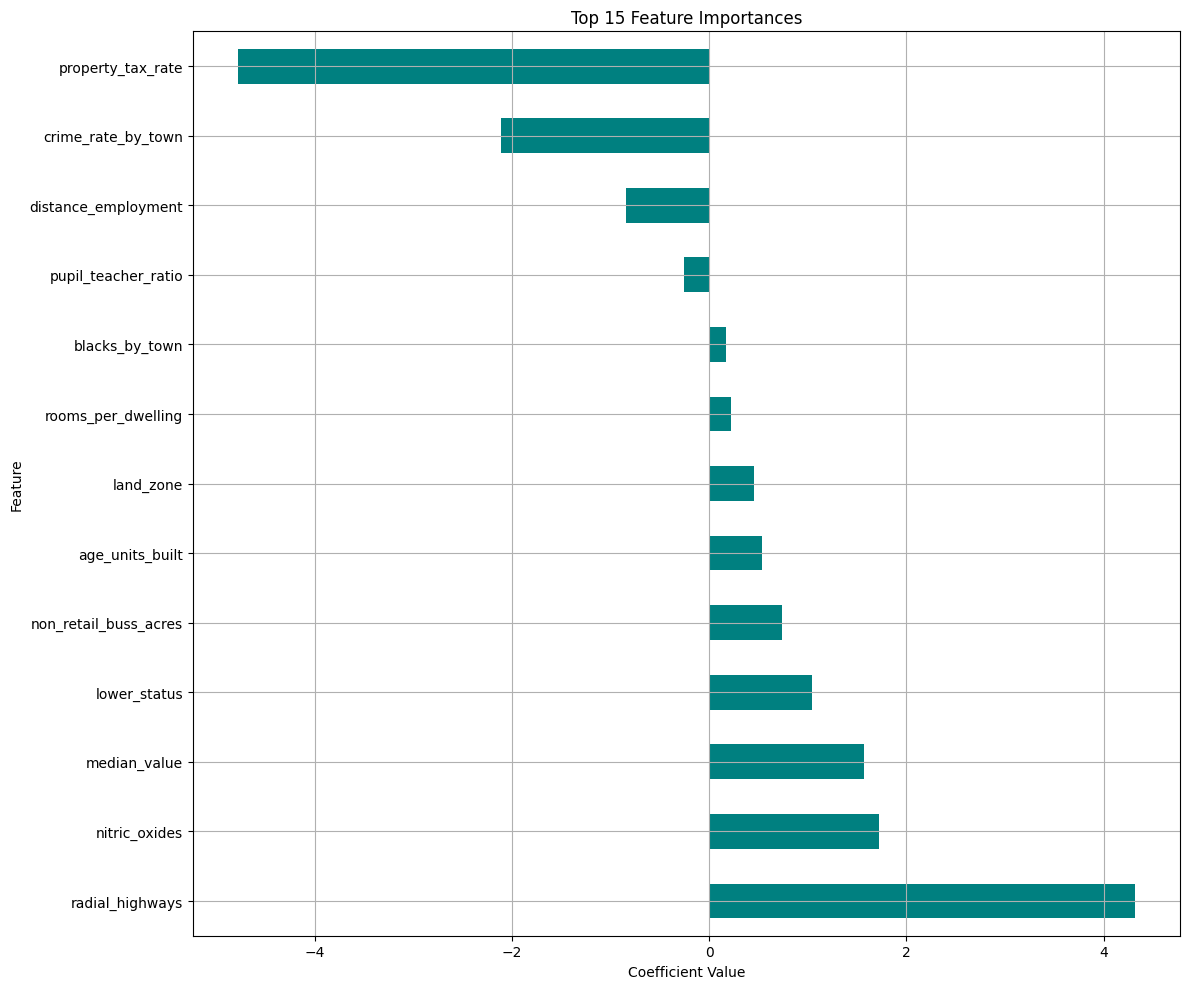

--- Top 10 Most Important Features ---
                       Coefficient
radial_highways           4.318787
nitric_oxides             1.723563
median_value              1.571909
lower_status              1.045354
non_retail_buss_acres     0.735867
age_units_built           0.535724
land_zone                 0.455726
rooms_per_dwelling        0.223848
blacks_by_town            0.166414
pupil_teacher_ratio      -0.252760
--- Bottom 10 Least Important Features ---
                       Coefficient
lower_status              1.045354
non_retail_buss_acres     0.735867
age_units_built           0.535724
land_zone                 0.455726
rooms_per_dwelling        0.223848
blacks_by_town            0.166414
pupil_teacher_ratio      -0.252760
distance_employment      -0.846788
crime_rate_by_town       -2.108572
property_tax_rate        -4.782175
-------------------------------------------------------------------------------------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/py

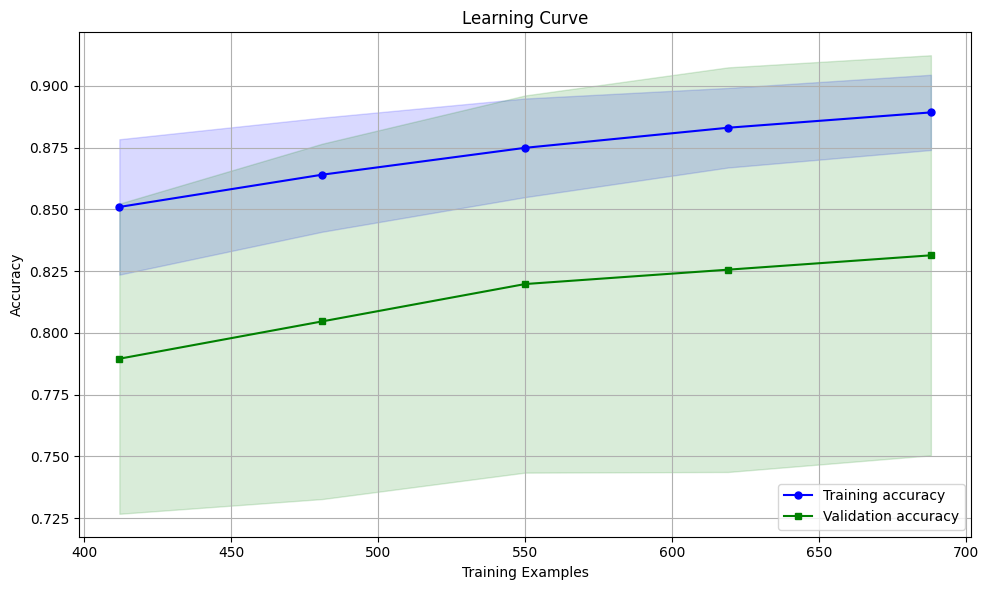

,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,1
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,1
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,1
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


In [33]:
# Logistic Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df.drop(columns=['charles_river'], axis=1)
y = df['charles_river']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

feature_names = X_train.columns  # or X.columns
target_names = y_train.values # or y.values 

# Basic model with default parameters 
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_train_lr = lr.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train_lr):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_lr)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train_lr)}")
print("-" * 127)  

# Basic model with default parameters using pipeline
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=42))  # Logistic regression model
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance Using Pipeline---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_pipeline)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train)}")

# Display confusion matrix
print("—- Confusion Matrix: -—")
print(f"Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred_pipeline)}\n")
print(f"Confusion Matrix train set:\n {confusion_matrix(y_train, y_pred_train)}")
print("-" * 127)  

# Hyperparameter tuning with GridSearchCV
print("--- Model With Hyperparameter Tuning ---")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],          # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],                               # Regularization type
    'classifier__solver': ['liblinear', 'saga'],                 # Algorithm to use
    'classifier__max_iter': [10000, 50000, 100000],  # Max iterations
    'classifier__class_weight': [None, 'balanced']      # Class weighting
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}\n")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print("-" * 127)  

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned_train = best_model.predict(X_train)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("--- Tuned Model Performance ---")
print(f"Accuracy Tuned Test: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy Tuned Train: {accuracy_score(y_train, y_pred_tuned_train):.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_tuned),'\n')
print(classification_report(y_train, y_pred_tuned_train))
print("-" * 127)   

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Basic Model Accuracy Pipeline: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_tuned):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_lr = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
cv_scores_basic_pipe = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_grid = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_lr}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_pipe}")
print(f"Tuned Model Grid Search Cross-Validation Scores: {cv_scores_tuned_grid}\n")

print(f"Basic Model Average CV Score LR:     {cv_scores_basic_lr.mean():.4f} ± {cv_scores_basic_lr.std():.4f}")
print(f"Basic Model Average CV Score Pipe:  {cv_scores_basic_pipe.mean():.4f} ± {cv_scores_basic_pipe.std():.4f}")
print(f"Tuned Model Average CV Score Grid:  {cv_scores_tuned_grid.mean():.4f} ± {cv_scores_tuned_grid.std():.4f}")
print("-" * 127)  

# Plot ROC curve
plt.figure(figsize=(10, 8))

# Calculate ROC curve for basic model using pipeline 
y_prob_basic = pipeline.predict_proba(X_test)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

# Calculate ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot both curves
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'Basic Model (AUC = {roc_auc_basic:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('roc_curve_comparison.png')
#plt.close() 
plt.show()

# Feature importance
final_model = best_model.named_steps['classifier']
if hasattr(final_model, 'coef_'):
    # Get feature importances (coefficients)
    importances = pd.DataFrame(
        final_model.coef_[0],
        index=X_train.columns,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importances.head(15)
    top_features['Coefficient'].plot(kind='barh', color='teal')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('feature_importance.png')
    #plt.close()
    plt.show()
    
    print("--- Top 10 Most Important Features ---")
    print(importances.head(10))
    print("--- Bottom 10 Least Important Features ---")
    print(importances.tail(10))
    print("-" * 127)  

# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

# Dataframe Predicted
base_model_df = pd.DataFrame(X_test)
base_model_df['prediction'] = np.round(y_pred_lr, 3)
display(base_model_df.head())

grid_model_df = pd.DataFrame(X_test)
grid_model_df['prediction'] = np.round(y_pred_tuned, 3)
display(grid_model_df.head())

pipe_model_df = pd.DataFrame(X_test)
pipe_model_df['prediction'] = np.round(y_pred_pipeline, 3)
display(pipe_model_df.head())  

## RandomForest Tuning 

Dataset shape: (860, 13)
Feature names: Index(['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status', 'median_value'], dtype='object')
Number of classes: 2
Class distribution: [430 430]

X Train shape: (688, 13)
Y Train shape: (688,)
X Test shape: (172, 13)
Y Test shape: (172,)
-------------------------------------------------------------------------------------------------------------------------------
--- Baseline Random Forest Results ---
Accuracy Test set: 0.9884
Accuracy Train set: 1.0000
Classification Report:
Classification Report Test: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        84
           1       0.98      1.00      0.99        88

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99    

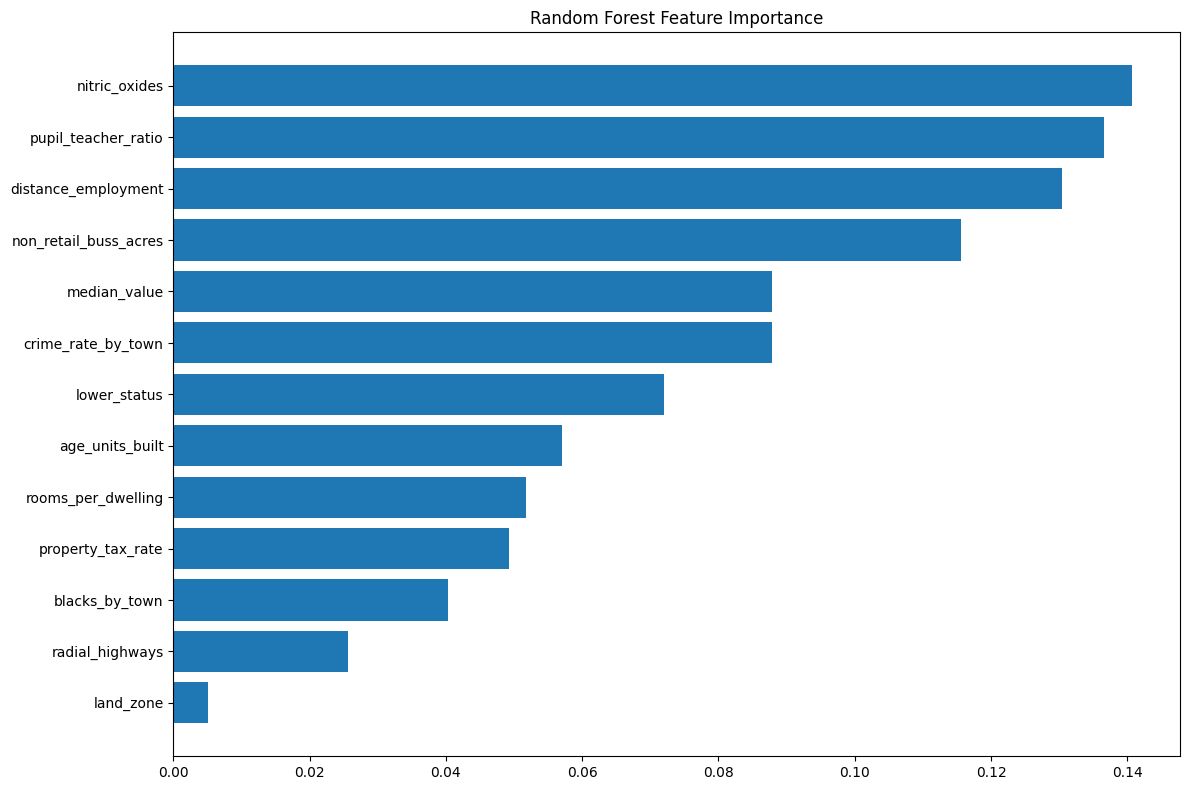

Cross-validation scores: [0.98550725 0.99275362 1.         0.97080292 0.97810219]
Mean CV accuracy: 0.9854
Standard deviation: 0.0103
-------------------------------------------------------------------------------------------------------------------------------


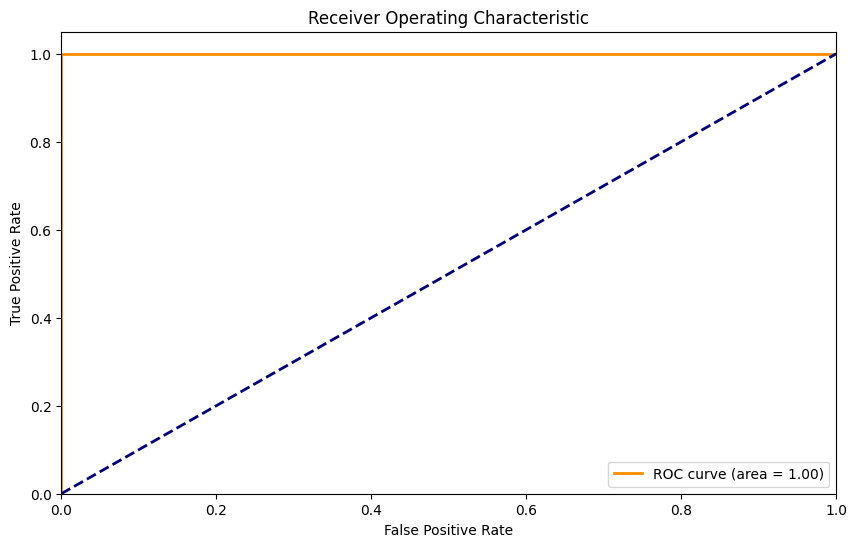

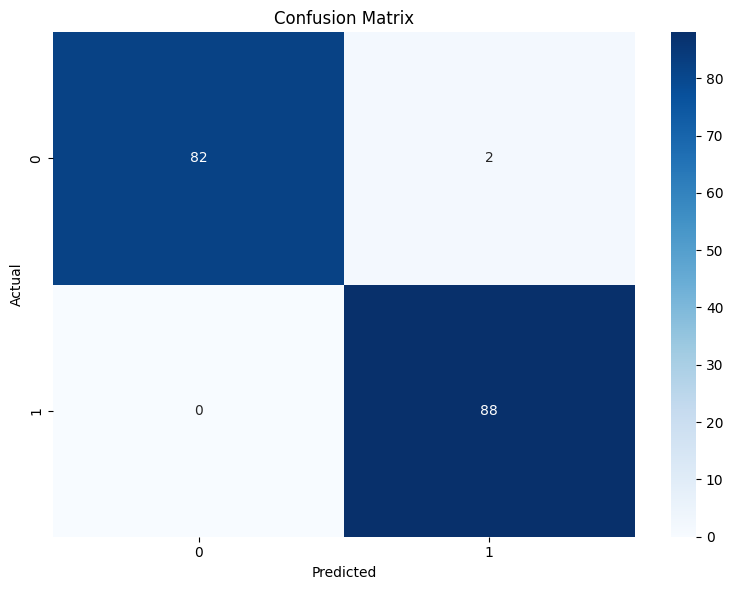

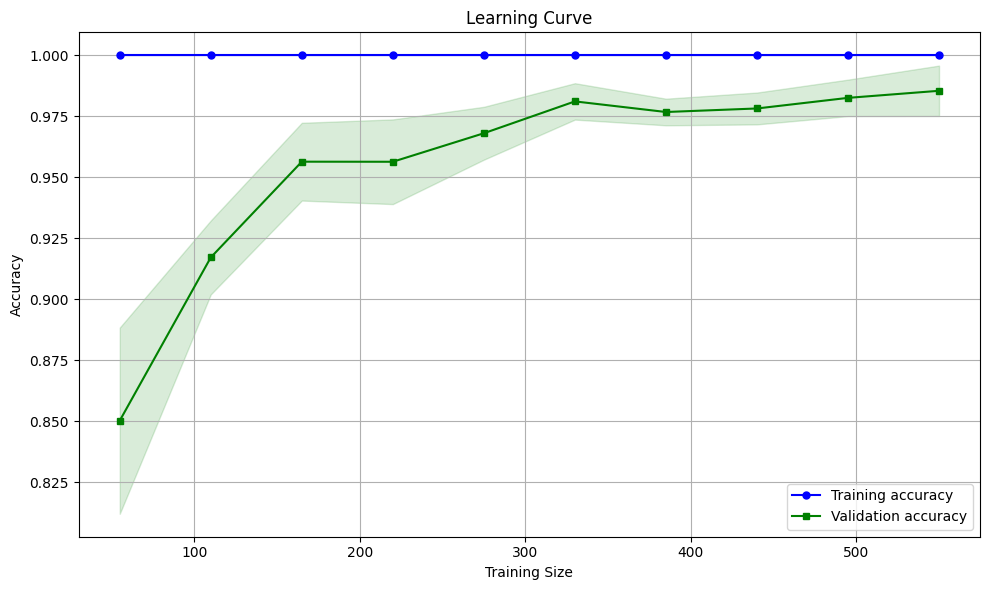

--- Fine-tuning n_estimators ---
Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fine-tuned n_estimators: 150
Fine-tuned accuracy: 0.9854
-------------------------------------------------------------------------------------------------------------------------------
--- Final Optimized Model Results ---
Final parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy Test: 0.9884
Accuracy Train: 1.0000
Classification Report:

Classification Report Test: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        84
           1       0.98      1.00      0.99        88

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172
 

Classification Report Train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       346
           1       1.00      1.0

,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,0
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,0
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,0
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


In [34]:
# RandomForest Tuning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.datasets import load_breast_cancer

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df.drop(columns=['charles_river'], axis=1)
y = df['charles_river']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Features and target names
feature_names = X.columns
target_names = ['0', '1']

# Feature scaling (optional for RandomForest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Basic Random Forest model (baseline)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train_scaled, y_train)
y_pred_base = rf_base.predict(X_test_scaled)
y_pred_base_train = rf_base.predict(X_train_scaled)

print("--- Baseline Random Forest Results ---")
print(f"Accuracy Test set: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Accuracy Train set: {accuracy_score(y_train, y_pred_base_train):.4f}")
print("Classification Report:")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_base, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_base_train, target_names=target_names))
print('-' *127)

# 2. GridSearchCV for hyperparameter tuning
print("--- Grid Search Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use smaller param_grid for demonstration purposes (to avoid long execution time)
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=small_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print('-' *127)

# 3. RandomizedSearchCV (more efficient for large parameter spaces)
print("--- Randomized Search Hyperparameter Tuning ---")
random_grid = {
    'n_estimators': np.arange(100, 500, 100),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': np.arange(2, 12, 2),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_grid,
    n_iter=20,  # Number of parameter settings sampled
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=42
)

randomized_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_:.4f}")
print('-' *127)

# 4. Evaluate the best model from GridSearchCV
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_scaled)
y_pred_grid_train = best_grid_model.predict(X_train_scaled)
y_prob_grid = best_grid_model.predict_proba(X_test_scaled)[:, 1]

print("--- Best Grid Search Model Evaluation ---")
print(f"Accuracy Test: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Accuracy Train: {accuracy_score(y_train, y_pred_grid_train):.4f}")
print("Classification Report:\n")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_grid, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_grid_train, target_names=target_names))
print('-' *127)

# 5. Feature importance analysis
feature_importances = best_grid_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importance')
plt.tight_layout()
#plt.savefig('feature_importance.png')
#plt.close()
plt.show()

# 6. Cross-validation of the best model
cv_scores = cross_val_score(best_grid_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")
print('-' *127)

# 7. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_grid)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('roc_curve.png')
#plt.close()
plt.show()

# 8. Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
#plt.savefig('confusion_matrix.png')
#plt.close()
plt.show()

# 9. Learning curves (optional for deeper analysis)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_grid_model, X_train_scaled, y_train, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

# 10. Fine-tuning specific parameters (optional based on previous findings)
# For example, fine-tuning n_estimators after discovering optimal ranges
print("--- Fine-tuning n_estimators ---")
estimator_range = np.arange(best_grid_model.n_estimators - 50, best_grid_model.n_estimators + 60, 10)
estimator_range = estimator_range[estimator_range > 0]  # Ensure positive values

param_grid_fine = {
    'n_estimators': estimator_range
}

# Create a new RF with the best parameters from before
rf_fine = RandomForestClassifier(
    random_state=42,
    max_depth=best_grid_model.max_depth,
    min_samples_split=best_grid_model.min_samples_split,
    # Add other parameters from best_grid_model as needed
)

grid_search_fine = GridSearchCV(
    estimator=rf_fine,
    param_grid=param_grid_fine,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search_fine.fit(X_train_scaled, y_train)
print(f"Fine-tuned n_estimators: {grid_search_fine.best_params_['n_estimators']}")
print(f"Fine-tuned accuracy: {grid_search_fine.best_score_:.4f}")
print('-' *127)

# 11. Final model with all optimized parameters
final_params = grid_search.best_params_.copy()
final_params['n_estimators'] = grid_search_fine.best_params_['n_estimators']

final_model = RandomForestClassifier(random_state=42, **final_params)
final_model.fit(X_train_scaled, y_train)
y_pred_final = final_model.predict(X_test_scaled)
y_pred_final_train = final_model.predict(X_train_scaled)

print("--- Final Optimized Model Results ---")
print(f"Final parameters: {final_params}")
print(f"Accuracy Test: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Accuracy Train: {accuracy_score(y_train, y_pred_final_train):.4f}")
print("Classification Report:\n")
print("Classification Report Test:",'\n', classification_report(y_test, y_pred_final, target_names=target_names),'\n')
print("Classification Report Train:",'\n', classification_report(y_train, y_pred_final_train, target_names=target_names))
print('-' *127)

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Basic Model Accuracy Pipeline Grid: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_final):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_rf = cross_val_score(rf_base, X, y, cv=5, scoring='accuracy')
cv_scores_basic_rf_grid = cross_val_score(best_grid_model, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_rf_grid = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_rf}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_rf_grid}")
print(f"Tuned Model Grid Search Cross-Validation Scores: {cv_scores_tuned_rf_grid}\n")

print(f"Basic Model Average CV Score RF:      {cv_scores_basic_rf.mean():.4f} ± {cv_scores_basic_rf.std():.4f}")
print(f"Basic Model Average CV Score Pipe RF: {cv_scores_basic_rf_grid.mean():.4f} ± {cv_scores_basic_rf_grid.std():.4f}")
print(f"Tuned Model Average CV Score Grid RF: {cv_scores_tuned_rf_grid.mean():.4f} ± {cv_scores_tuned_rf_grid.std():.4f}")
print("-" * 127)  

# Dataframe Predicted
base_model_df = pd.DataFrame(X_test)
base_model_df['prediction'] = np.round(y_pred_base, 3)
display(base_model_df.head())

grid_model_df = pd.DataFrame(X_test)
grid_model_df['prediction'] = np.round(y_pred_grid, 3)
display(grid_model_df.head())

pipe_model_df = pd.DataFrame(X_test)
pipe_model_df['prediction'] = np.round(y_pred_final, 3)
display(pipe_model_df.head()) 

## Bagging Tuning 

Dataset shape: (860, 13)
Feature names: Index(['crime_rate_by_town', 'land_zone', 'non_retail_buss_acres', 'nitric_oxides', 'rooms_per_dwelling', 'age_units_built', 'distance_employment', 'radial_highways', 'property_tax_rate', 'pupil_teacher_ratio', 'blacks_by_town', 'lower_status', 'median_value'], dtype='object')
Number of classes: 2
Class distribution: [430 430]

X Train shape: (688, 13)
Y Train shape: (688,)
X Test shape: (172, 13)
Y Test shape: (172,)
-------------------------------------------------------------------------------------------------------------------------------
BaggingClassifier Accuracy test set: 0.9826
BaggingClassifier Accuracy train set: 1.0000
Starting grid search...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Grid search completed!

Best parameters: {'bootstrap': False, 'bootstrap_features': True, 'estimator__max_depth': None, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
Best cross-validation score: 0.9942

Tuned BaggingCl

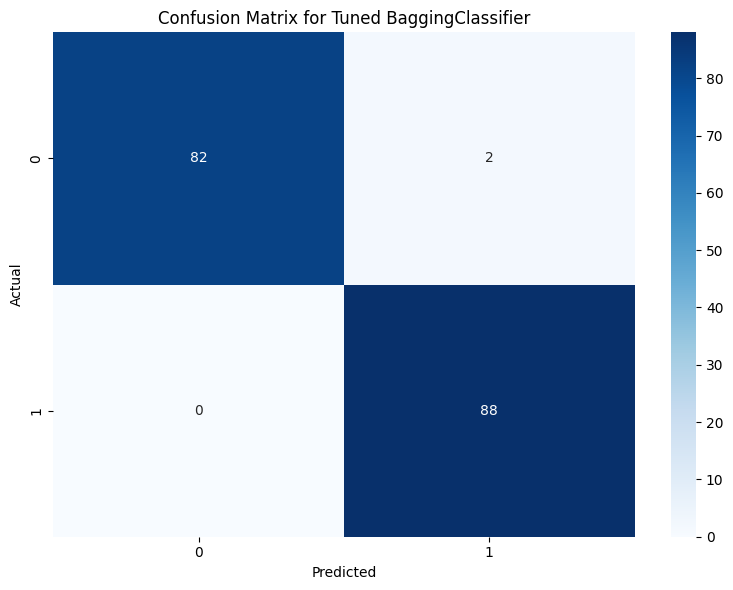

Feature importances not available for this model


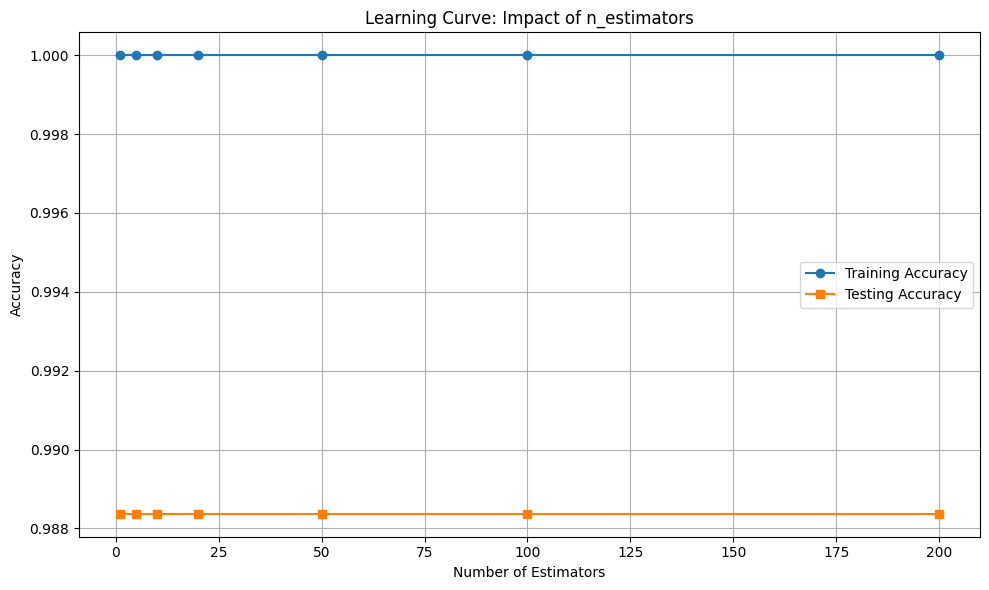

,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,0
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,0
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


,crime_rate_by_town,land_zone,non_retail_buss_acres,nitric_oxides,rooms_per_dwelling,age_units_built,distance_employment,radial_highways,property_tax_rate,pupil_teacher_ratio,blacks_by_town,lower_status,median_value,prediction
714,3.32105,0.0,19.58,0.871,5.403,100.0,1.3216,5,403.0,14.7,396.90,26.82,13.4,1
605,0.04560,0.0,13.89,0.550,5.888,56.0,3.1121,5,276.0,16.4,392.80,13.51,23.3,1
120,0.09849,0.0,25.65,0.581,5.879,95.8,2.0063,2,188.0,19.1,379.38,17.58,18.8,1
208,0.08221,22.0,5.86,0.431,6.957,6.8,8.9067,7,330.0,19.1,386.09,3.53,29.6,0
380,4.66883,0.0,18.10,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01,12.7,0


In [35]:
# Bagging Tuning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Prepare the data
X = df.drop(columns=['charles_river'], axis=1)
y = df['charles_river']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a base classifier (Decision Tree in this case)
base_clf = DecisionTreeClassifier(random_state=42)

# Create and train a simple BaggingClassifier with default parameters
bag_clf = BaggingClassifier(estimator=base_clf, random_state=42)
bag_clf.fit(X_train_scaled, y_train)

# Evaluate initial model
y_pred = bag_clf.predict(X_test_scaled)
y_pred_train = bag_clf.predict(X_train_scaled)

# Initial accuracy
initial_accuracy = accuracy_score(y_test, y_pred)

print(f"BaggingClassifier Accuracy test set: {accuracy_score(y_test, y_pred):.4f}")
print(f"BaggingClassifier Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'estimator__max_depth': [None, 5, 10]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=BaggingClassifier(estimator=base_clf, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to find best parameters
print("Starting grid search...")
grid_search.fit(X_train_scaled, y_train)
print("Grid search completed!")

# Get best parameters and score
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}\n")

# Get the best model
best_bag_clf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred_tuned = best_bag_clf.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Tuned BaggingClassifier Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement: {tuned_accuracy - initial_accuracy:.4f}")

# Generate classification report
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_tuned)
classes = sorted(y_test.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned BaggingClassifier')
plt.tight_layout()
plt.show()

# Visualize feature importance (if available)
if hasattr(best_bag_clf, 'feature_importances_'):
    feature_importances = best_bag_clf.estimator_.feature_importances_
    feature_names = X_train.columns
    
    # Get top 10 features
    indices = np.argsort(feature_importances)[::-1][:10]
    
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importances')
    plt.bar(range(10), feature_importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model")

# Analyzing the impact of n_estimators
n_estimators_range = [1, 5, 10, 20, 50, 100, 200]
train_scores = []
test_scores = []

for n_estimators in n_estimators_range:

    # Create model with current n_estimators value
    bag = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=best_bag_clf.estimator_.max_depth),
        n_estimators=n_estimators,
        max_samples=best_bag_clf.max_samples,
        max_features=best_bag_clf.max_features,
        bootstrap=best_bag_clf.bootstrap,
        bootstrap_features=best_bag_clf.bootstrap_features,
        random_state=42
    )
    
    # Train model
    bag.fit(X_train_scaled, y_train)
    
    # Evaluate on train and test sets
    train_score = accuracy_score(y_train, bag.predict(X_train_scaled))
    test_score = accuracy_score(y_test, bag.predict(X_test_scaled))
    
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, label='Testing Accuracy', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Impact of n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Dataframe Predicted
base_model_df = pd.DataFrame(X_test)
base_model_df['prediction'] = np.round(y_pred, 3)
display(base_model_df.head())

grid_model_df = pd.DataFrame(X_test)
grid_model_df['prediction'] = np.round(y_pred_grid, 3)
display(grid_model_df.head())

pipe_model_df = pd.DataFrame(X_test)
pipe_model_df['prediction'] = np.round(y_pred_pipeline, 3)
display(pipe_model_df.head()) 
